# 0.0 - Imports

In [1]:
import os
import re
import optuna
import pickle
import warnings

import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import matplotlib.ticker       as mtick
import seaborn                 as sns
import lightgbm                as lgb
import xgboost                 as xgb

from scipy                     import stats
from IPython.display           import display, HTML
from xgboost                   import XGBRegressor, plot_importance
from sklearn.model_selection   import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing     import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model      import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.ensemble          import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors         import KNeighborsRegressor
from sklearn.metrics           import make_scorer, mean_absolute_error, mean_squared_error, r2_score


# 0.1 - Helper Function

In [2]:
# %matplotlib inline
# %pylab inline
    
# plt.style.use('bmh')
# plt.rcParams['figure.figsize'] = [25, 12]
# plt.rcParams['font.size'] = 24
    
# display (HTML('<style>.container { width:100% !important; }</style>'))
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
# pd.set_option('display.expand_frame_repr', False)

In [3]:
pd.set_option('display.float_format', '{:,.2f}'.format)

display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output { max-height: 1000px !important; }</style>"))


def descriptive_statistics(df):
    num_attributes = df.select_dtypes(include=['int64', 'float64'])
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    d1 = pd.DataFrame(num_attributes.apply(np.std) ).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x, 25))).T
    d8 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x, 50))).T
    d9 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x, 75))).T
    d10 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x, 90))).T
    d11 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x, 99))).T
    de_table = pd.concat([d4, ct1, ct2, d1, d5, d6, d2, d7, d8, d9, d10, d11, d3]).T.reset_index()
    de_table.columns = ['attributes', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis', 'min', '25%', '50%', '75%', '90%', '99%', 'max']
    pd.set_option('display.float_format', '{:.2f}'.format)
    pd.options.display.float_format = '{:,.2f}'.format
    return de_table

pd.options.display.float_format = None


from IPython.display import HTML
HTML('<style>.container { width:100% !important; }</style>')
plt.rcParams['figure.dpi'] = 100

# Define a função para formatar o eixo x em milhares
def milhares_x(x, pos):
    return '{:.0f}k'.format(x/1000)

# Define a função para formatar o eixo x em milhões
def milhoes_x(x, pos):
    return '{:.0f}m'.format(x/1000000)

# Define a função para formatar o eixo y em milhares
def milhares_y(y, pos):
    return '{:.0f}k'.format(y/1000)

# Define a função para formatar o eixo y em milhões
def milhoes_y(y, pos):
    return '{:.0f}m'.format(y/1000000)

def plot_count_percentage(data, x, title, ax, dp=2, percent_fontsize=8):
    sns.countplot(x=x, data=data, ax=ax, palette='Greens_r', order=data[x].value_counts().index)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
    ax.set_title(title)

    total = len(data[x])
    for p in ax.patches:
        percentage = p.get_height() / total
        formatted_percentage = f"{percentage:.{dp}%}"
        ax.text(p.get_x() + p.get_width() / 2,
                p.get_height(),
                formatted_percentage,
                ha='center',
                va='bottom',
                fontsize=percent_fontsize)

sns.set_theme(style="whitegrid")


def plot_count_percentage_horizontal(data, x, title, ax, dp=2, percent_fontsize=10, top_n=None, show_absolute=True, show_percent=True):
    if top_n is not None:
        data_subset = data[x].value_counts().head(top_n).reset_index()
        data_subset.columns = [x, 'Count']
    else:
        data_subset = data[x].value_counts().reset_index()
        data_subset.columns = [x, 'Count']

    sns.barplot(x='Count', y=x, data=data_subset, ax=ax, palette='Greens_r')
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
    ax.set_title(title)

    total_subset = len(data_subset)

    for p in ax.patches:
        width = p.get_width()
        index = int(p.get_y())

        if 0 <= index < len(data_subset):
            model_name = data_subset.loc[index, x]
            total = len(data[x])  # Use the total count from the original dataset
            percentage = (width / total) * 100

            label = ''
            if show_absolute:
                label += f'{width:.0f}'
            if show_absolute and show_percent:
                label += ' '
            if show_percent:
                label += f'({percentage:.2f}%)'

            ax.annotate(label,
                        (width, p.get_y() + p.get_height() / 2),
                        va='center', ha='left', xytext=(2, 0), textcoords='offset points')

def identificar_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 5 * IQR
    limite_superior = Q3 + 5 * IQR
    outliers = (series < limite_inferior) | (series > limite_superior)
    return outliers

def create_counts_df(data):
    counts_df = data.groupby(['TipoVendedor', 'TipoAnuncio']).size().unstack(fill_value=0)
    return counts_df


def plot_combined_bar_chart(data, ax, title, dp=2, percent_fontsize=12):
    counts_df = create_counts_df(data)
    counts_df.plot(kind='bar', stacked=True, ax=ax, color=sns.color_palette("Greens_r", len(counts_df.columns)))

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.set_xlabel('TipoVendedor')

    plt.xticks(rotation=0)
    plt.legend(title='TipoAnuncio', bbox_to_anchor=(1.05, 1), loc='upper left')

    total = counts_df.sum(axis=1).sum()
    for p in ax.patches:
        percentage = p.get_height() / total
        formatted_percentage = f"{percentage:.{dp}%}"

        # Adicione esta verificação para evitar mostrar 0,00%
        if percentage > 0:
            ax.text(p.get_x() + p.get_width() / 2,
                    p.get_height(),
                    formatted_percentage,
                    ha='center',
                    va='bottom',
                    fontsize=percent_fontsize)
            
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [4]:
def remove_outliers(df, column_name, lower_multiplier=1, upper_multiplier=1):
    # Calcular Q1, Q3 e IQR
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Identificar outliers usando o critério IQR
    outliers = ~((df[column_name] < (Q1 - lower_multiplier * IQR)) | (df[column_name] > (Q3 + upper_multiplier * IQR)))

    # Filtrar os dados removendo os outliers
    df_filtered = df[outliers]

    # Exibir informações sobre os outliers removidos
    n_outliers = (~outliers).sum()
    print(f"Número de outliers removidos em {column_name}: {n_outliers}")

    # Resetar o índice para garantir um índice padrão
    df_filtered.reset_index(drop=True, inplace=True)

    return df_filtered

# 0.3 - Data

## 0.3.1 - Upload Data

In [64]:
df_raw = pd.read_csv(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\Data\WebMotors - All.csv', encoding='utf-8')

## 0.3.2 - Split data into train and test

In [82]:
# Separating target variable
X = df_raw.drop('Valor', axis=1)
y = df_raw['Valor']

# Spliting train and test datasets
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42)

# Concatenating target variable into train and test datasets
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

# 1.0 - Data Description

In [7]:
df1 = df_train.copy()

In [8]:
df1 = df1.drop_duplicates(subset=['UniqueId'], keep='first')

## 1.1 - Data Types

In [8]:
df1.dtypes

UniqueId           int64
Titulo            object
Marca             object
Modelo            object
Versao            object
AnoFabricacao      int64
AnoModelo        float64
Cidade            object
Estado            object
KM               float64
Cambio            object
NumeroPortas       int64
TipoCorpo         object
UnicoDono           bool
IPVAPago            bool
Licenciado          bool
Blindado          object
Cor               object
TipoVendedor      object
TipoAnuncio       object
NomeFantasia      object
Fipe               int64
Link              object
Valor            float64
dtype: object

In [9]:
df1['AnoModelo'] = df1['AnoModelo'].astype('int64')

## 1.2 - Data Dimensions

In [10]:
print(f'Number of Columns: {df1.shape[1]}')
print(f'Number of Rows:    {df1.shape[0]:n}')

Number of Columns: 24
Number of Rows:    566630


In [11]:
# Remover todos os anúncios duplicados (provavelmente apareceram mais de uma vez no momento da coleta dos dados devido a anúncio pago pela parte do vendedor)
df1 = df1.drop_duplicates(subset=['UniqueId'], keep='first')

In [12]:
print(f'Number of Columns: {df1.shape[1]}')
print(f'Number of Rows:    {df1.shape[0]:n}')

Number of Columns: 24
Number of Rows:    412929


## 1.3 - Check NA

In [13]:
df1.isna().sum()

UniqueId             0
Titulo               0
Marca                0
Modelo               0
Versao               0
AnoFabricacao        0
AnoModelo            0
Cidade               0
Estado               0
KM                   0
Cambio               0
NumeroPortas         0
TipoCorpo           14
UnicoDono            0
IPVAPago             0
Licenciado           0
Blindado             0
Cor                  0
TipoVendedor         0
TipoAnuncio          0
NomeFantasia     81254
Fipe                 0
Link                 0
Valor                0
dtype: int64

In [14]:
df1['NomeFantasia'] = df1['NomeFantasia'].fillna('PF')
df1.isna().sum()

UniqueId          0
Titulo            0
Marca             0
Modelo            0
Versao            0
AnoFabricacao     0
AnoModelo         0
Cidade            0
Estado            0
KM                0
Cambio            0
NumeroPortas      0
TipoCorpo        14
UnicoDono         0
IPVAPago          0
Licenciado        0
Blindado          0
Cor               0
TipoVendedor      0
TipoAnuncio       0
NomeFantasia      0
Fipe              0
Link              0
Valor             0
dtype: int64

## 1.4 - Descriptive statistics

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.4.1 - Numerical Attributes

In [16]:
descriptive_statistics(num_attributes)

,attributes,range,media,mediana,std,skew,kurtosis,min,25%,50%,75%,90%,99%,max
0,UniqueId,"49,128,477.00","49,377,834.15","50,088,993.00","2,422,782.95",-7.06,77.91,"1,549,992.00","49,283,244.00","50,088,993.00","50,388,146.00","50,579,220.20","50,666,714.72","50,678,469.00"
1,AnoFabricacao,98.00,"2,017.22","2,019.00",5.70,-3.75,26.01,"1,926.00","2,015.00","2,019.00","2,021.00","2,022.00","2,023.00","2,024.00"
2,AnoModelo,98.00,"2,017.81","2,019.00",5.75,-3.77,26.15,"1,926.00","2,015.00","2,019.00","2,022.00","2,023.00","2,023.00","2,024.00"
3,KM,"2,147,483,647.00","150,038.73","63,510.00","8,152,772.76",142.43,"23,609.49",0.00,"40,496.00","63,510.00","99,000.00","140,000.00","257,000.00","2,147,483,647.00"
4,NumeroPortas,4.00,3.74,4.00,0.81,-3.34,10.80,0.00,4.00,4.00,4.00,4.00,4.00,4.00
5,Fipe,"2,937,681.00",210.16,103.00,"9,482.89",221.11,"55,773.34",57.00,98.00,103.00,108.00,120.00,666.00,"2,937,738.00"
6,Valor,"1,111,107,168.00","210,729.98","81,990.00","7,135,960.51",128.39,"18,984.98","4,000.00","57,890.00","81,990.00","123,990.00","199,900.00","698,000.00","1,111,111,168.00"


Text(0.5, 1.0, 'Fipe')

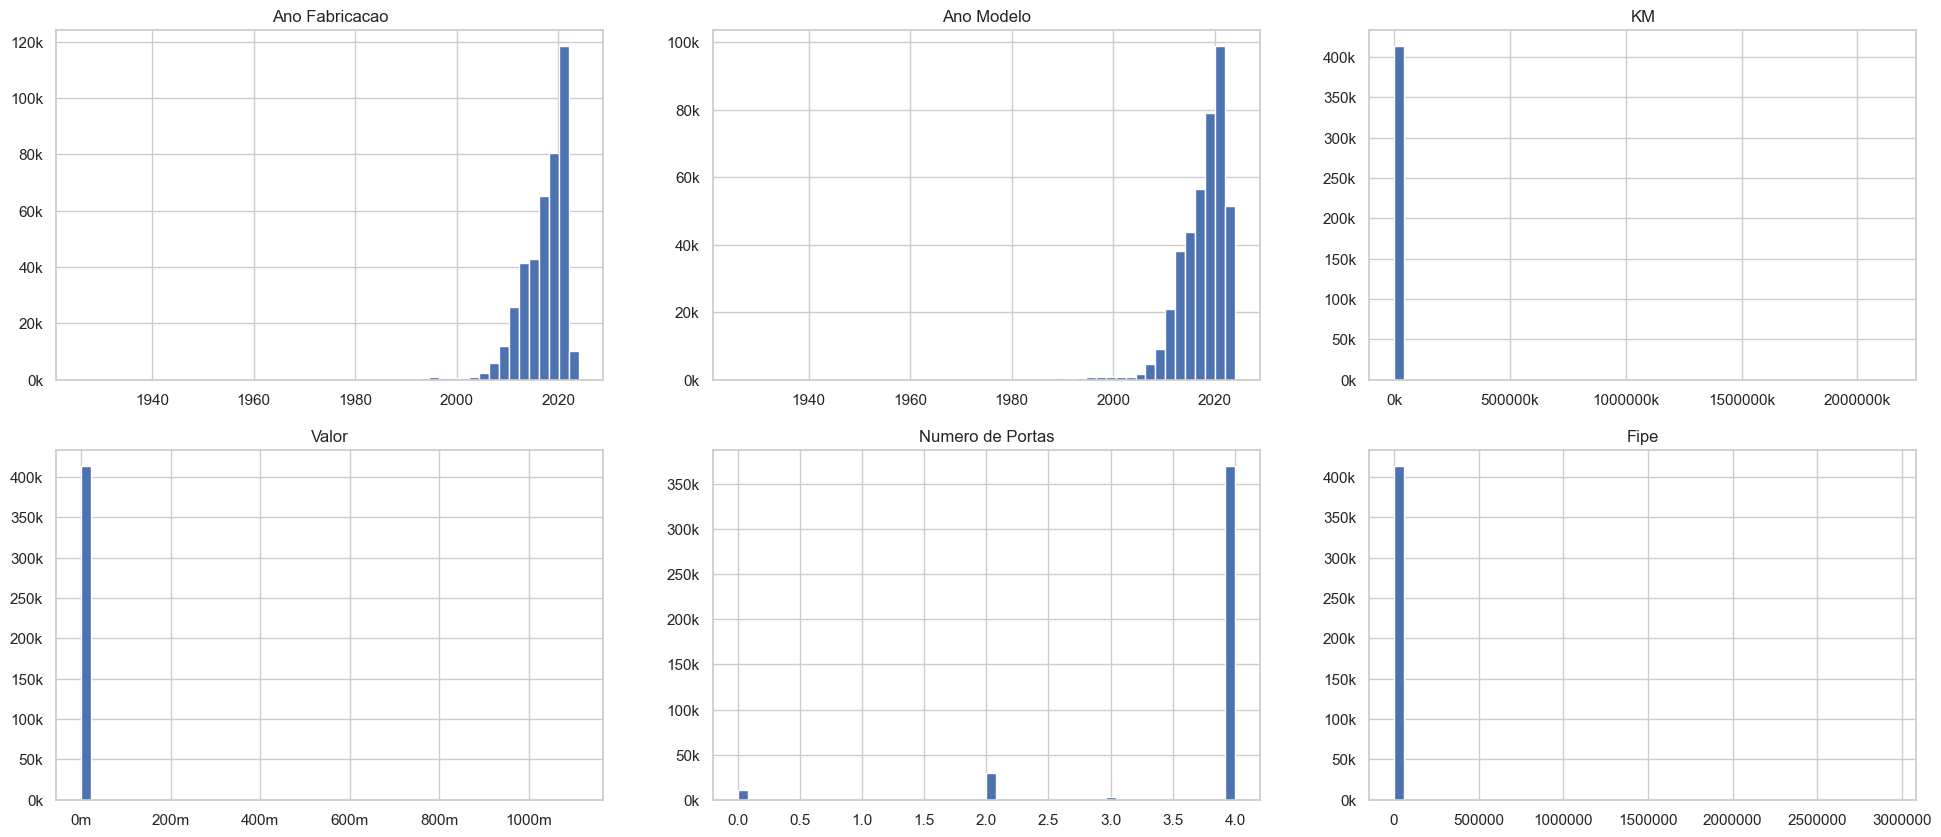

In [17]:
plt.subplot(2, 3, 1)
df1['AnoFabricacao'].hist(bins= 50, figsize=(24,12))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Ano Fabricacao")

plt.subplot(2, 3, 2)
df1['AnoModelo'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Ano Modelo")

plt.subplot(2, 3, 3)
df1['KM'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(milhares_x))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("KM")

plt.subplot(2, 3, 4)
df1['Valor'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(milhoes_x))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Valor")

plt.subplot(2, 3, 5)
df1['NumeroPortas'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Numero de Portas")

plt.subplot(2, 3, 6)
df1['Fipe'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Fipe")


*   The histogram presented allows us to identify that the data for the Fipe, KM, and Valor features are mostly concentrated in the first bin.
*   Such a wide variation, combined with a distribution that is so heavily skewed toward the first bin, indicates the presence of outliers.
* The distribution of 'Ano Modelo' and 'Ano Fabricação' is largely concentrated after 2000.

### 1.4.2 - Categorical Attributes

In [18]:
cat_attributes.describe().T

,count,unique,top,freq
Titulo,412929,7573,FIAT MOBI 1.0 EVO FLEX LIKE. MANUAL,5656
Marca,412929,114,VOLKSWAGEN,63830
Modelo,412929,1098,ONIX,16003
Versao,412929,6664,1.0 12V MPI TOTALFLEX 4P MANUAL,6041
Cidade,412929,1884,São Paulo,66408
Estado,412929,27,São Paulo (SP),181900
Cambio,412929,7,Automática,236437
TipoCorpo,412915,10,Utilitário esportivo,147921
UnicoDono,412929,2,False,329172
IPVAPago,412929,2,False,276834


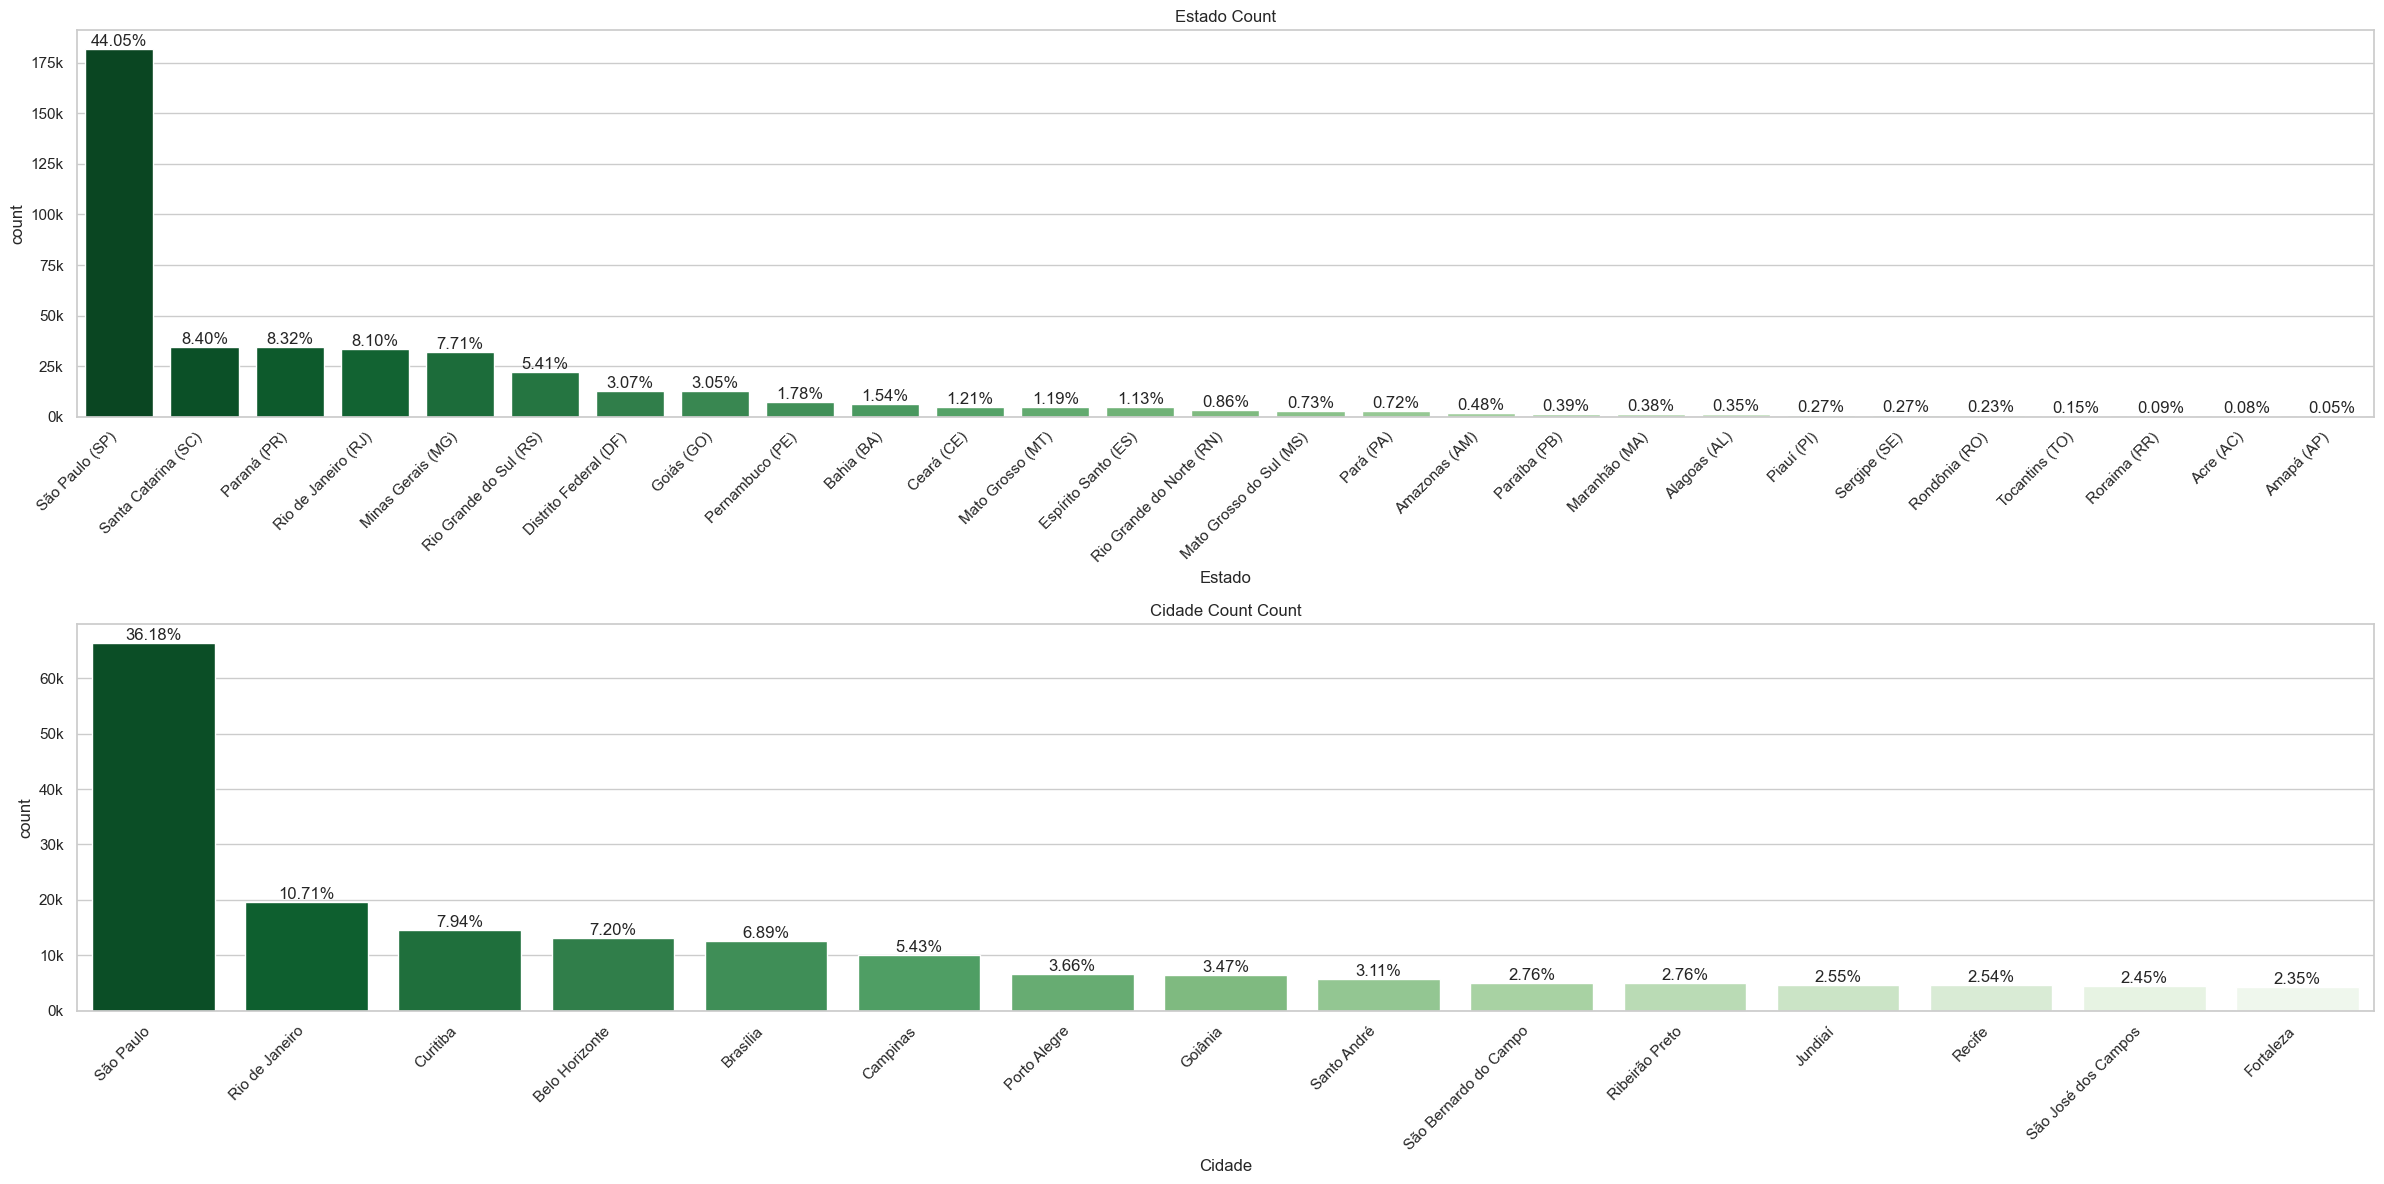

In [19]:
df_aux = df1['Cidade'].value_counts(normalize=True).reset_index()
df_aux = df_aux[df_aux['proportion'] >= 0.01]
top_cidades = df_aux['Cidade']
df_aux2 = df1[df1['Cidade'].isin(top_cidades)]

fig, axs = plt.subplots(2, 1, figsize=(24,12))

plot_count_percentage(df1, 'Estado', 'Estado Count', axs[0], 2, 12)
plot_count_percentage(df_aux2, 'Cidade', 'Cidade Count Count', axs[1], 2, 12)

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
plt.tight_layout()
plt.show()

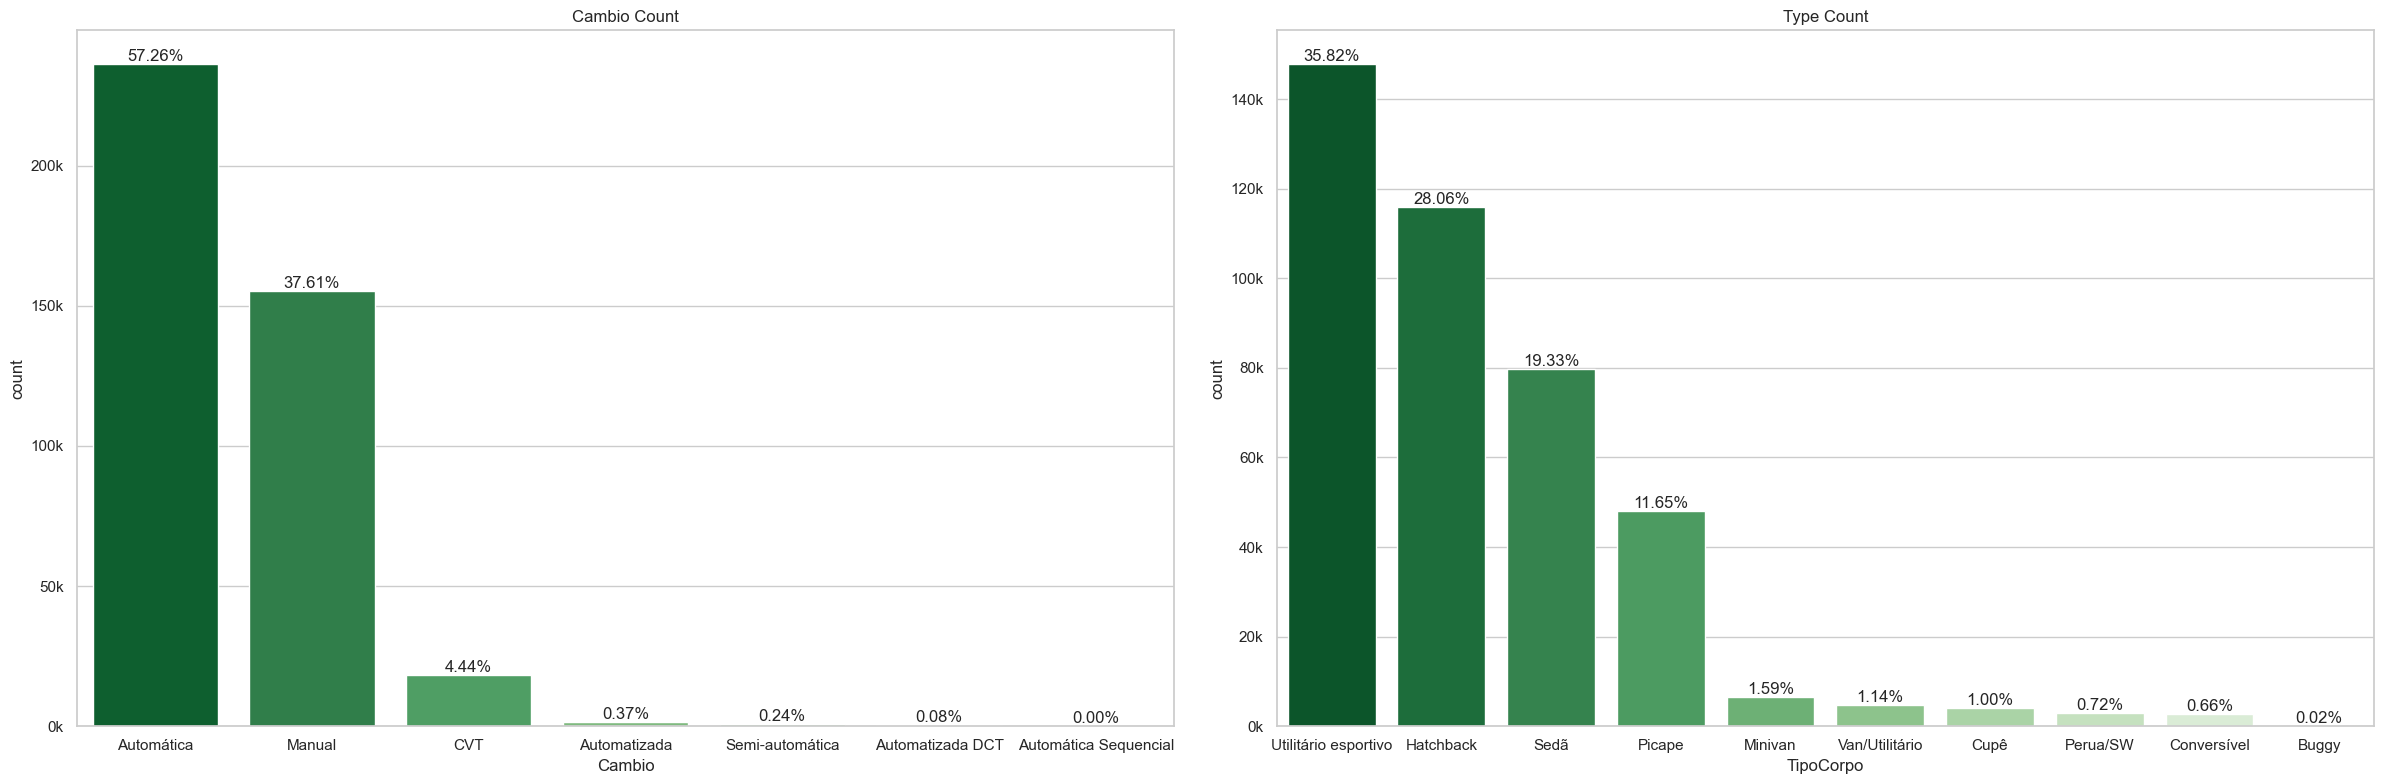

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(24,8))

plot_count_percentage(df1, 'Cambio', 'Cambio Count', axs[0], 2, 12)
plot_count_percentage(df1, 'TipoCorpo', 'Type Count', axs[1], 2, 12)

plt.tight_layout()
plt.show()

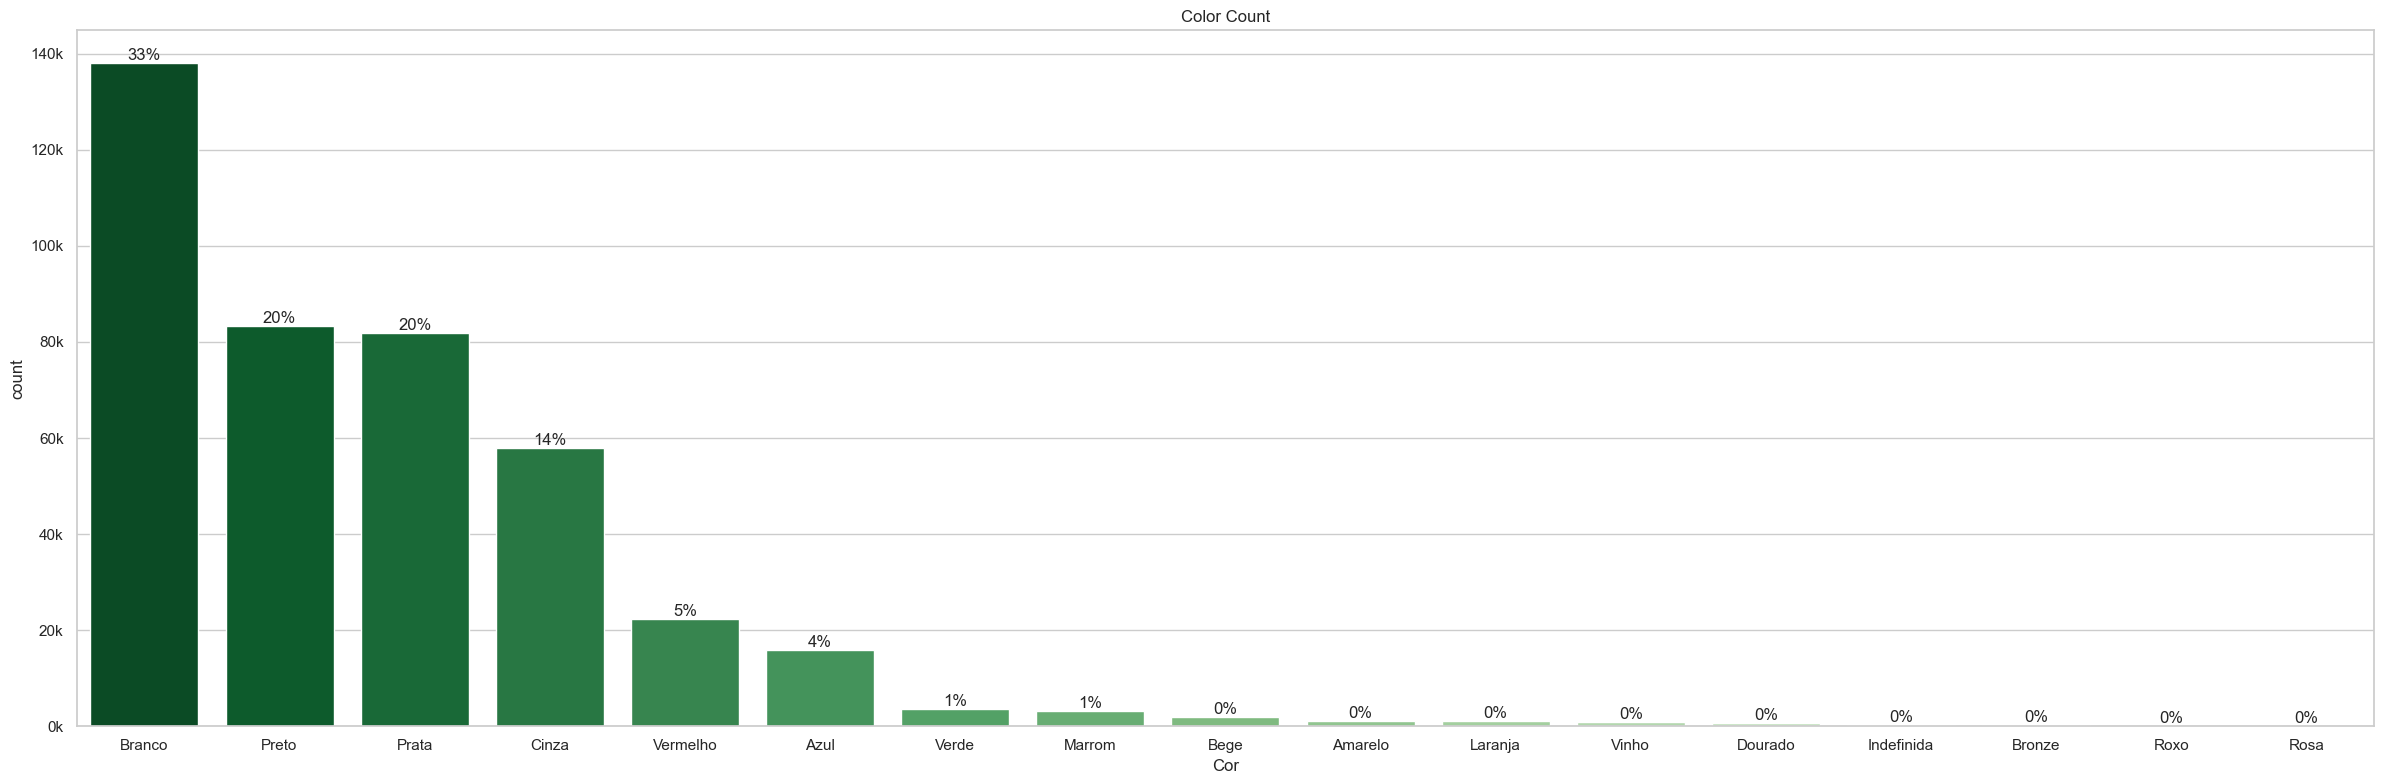

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(24,8))

plot_count_percentage(df1, 'Cor', 'Color Count', axs, 0, 12)

plt.tight_layout()
plt.show()

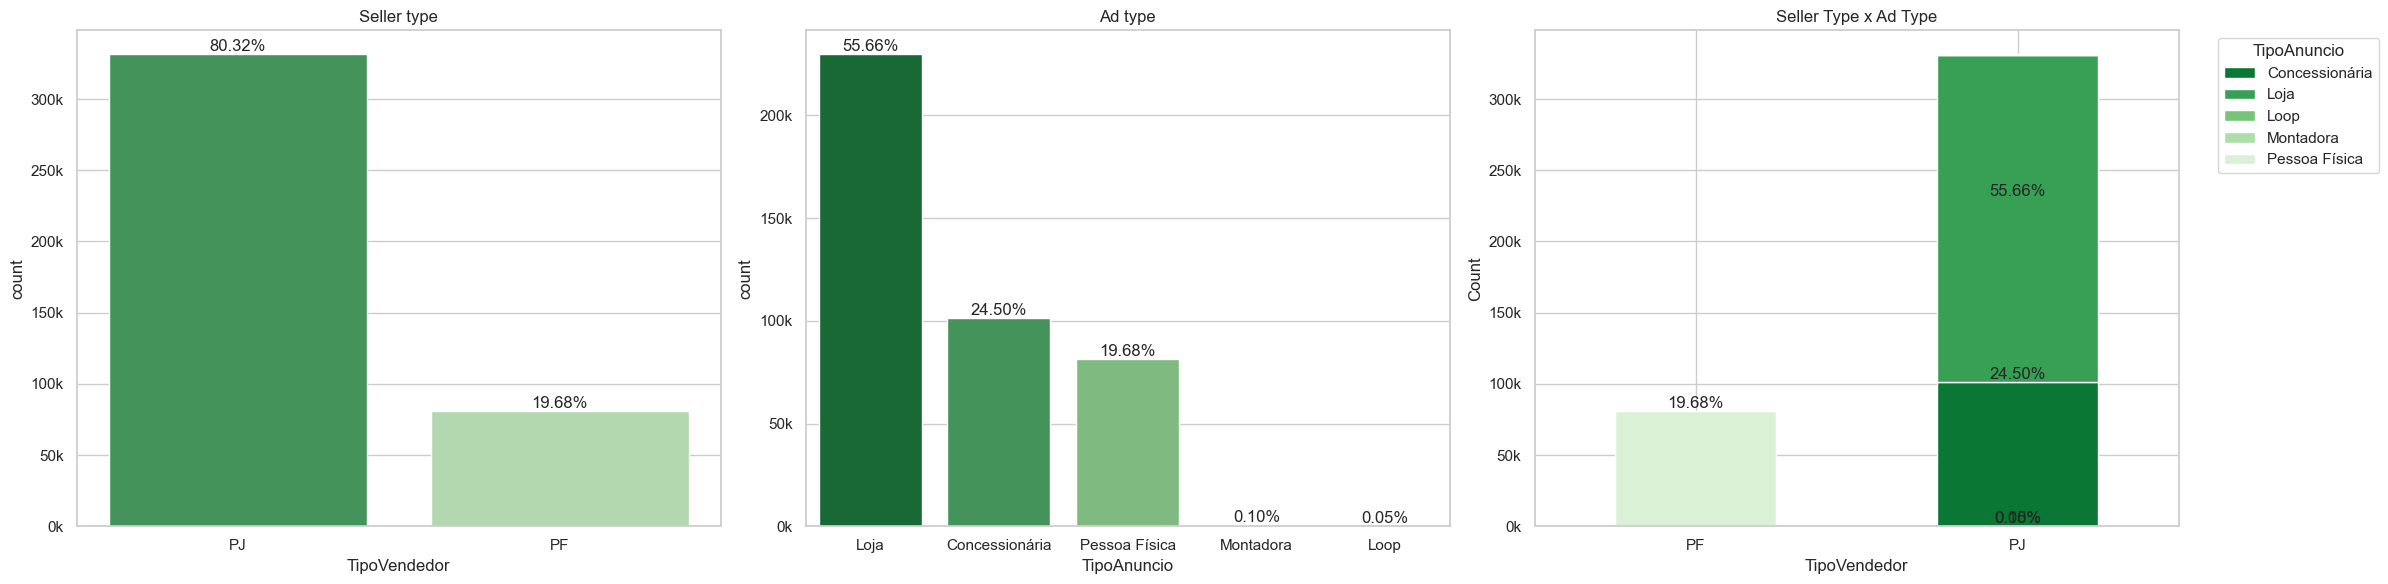

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

plot_count_percentage(df1, 'TipoVendedor', 'Seller type', axs[0], 2, 12)
plot_count_percentage(df1, 'TipoAnuncio', 'Ad type', axs[1], 2, 12)
plot_combined_bar_chart(df1, axs[2], 'Seller Type x Ad Type')

plt.tight_layout()
plt.show()

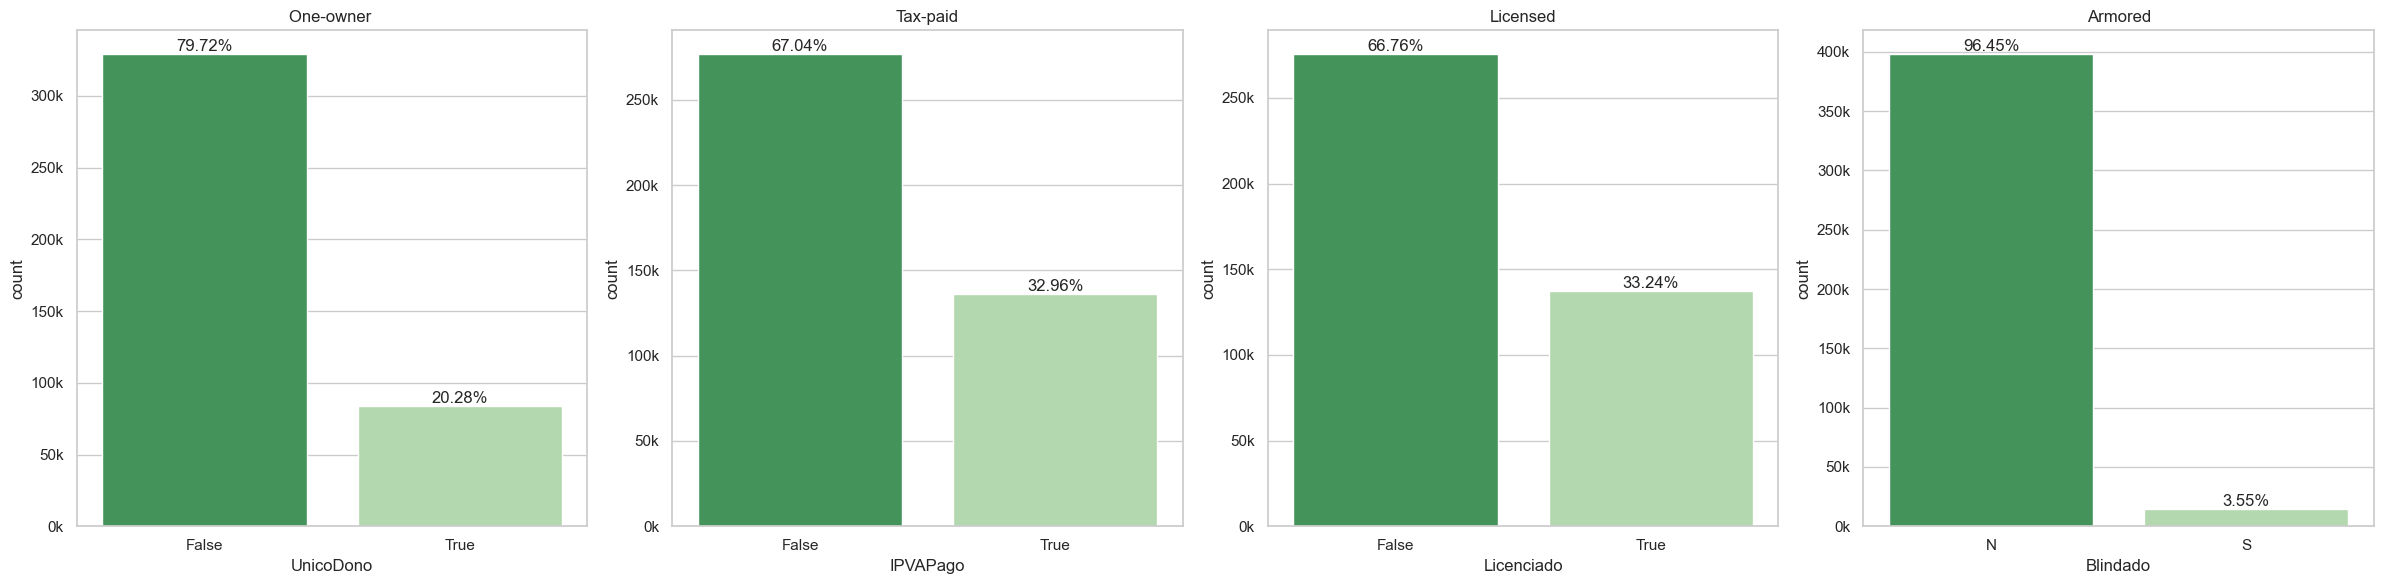

In [23]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

plot_count_percentage(df1, 'UnicoDono', 'One-owner ', axs[0], 2, 12)
plot_count_percentage(df1, 'IPVAPago', 'Tax-paid', axs[1], 2, 12)
plot_count_percentage(df1, 'Licenciado', 'Licensed', axs[2], 2, 12)
plot_count_percentage(df1, 'Blindado', 'Armored', axs[3], 2, 12)
plt.tight_layout()
plt.show()

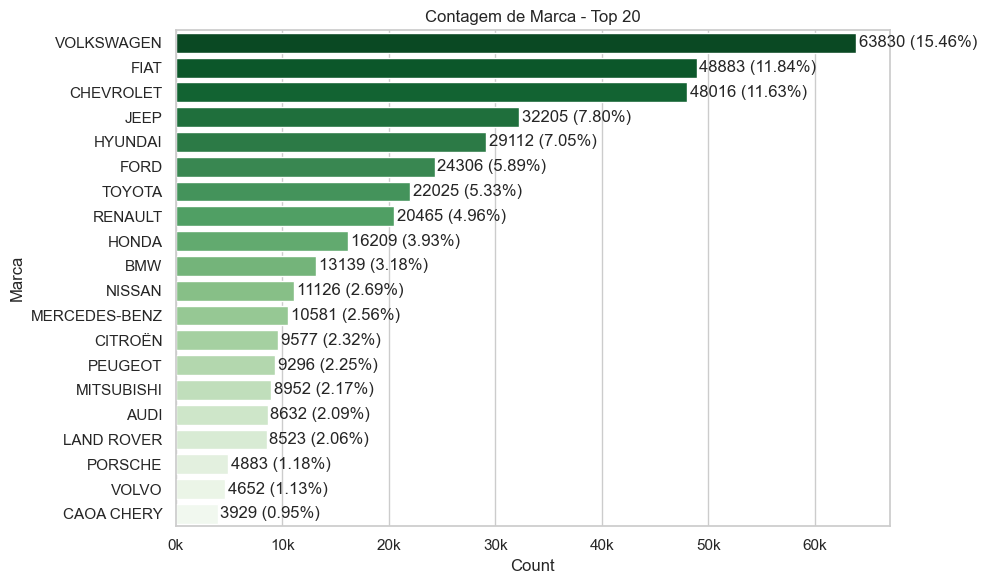

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_count_percentage_horizontal(df1, 'Marca', 'Contagem de Marca - Top 20', ax, top_n=20)
plt.tight_layout()
plt.show()

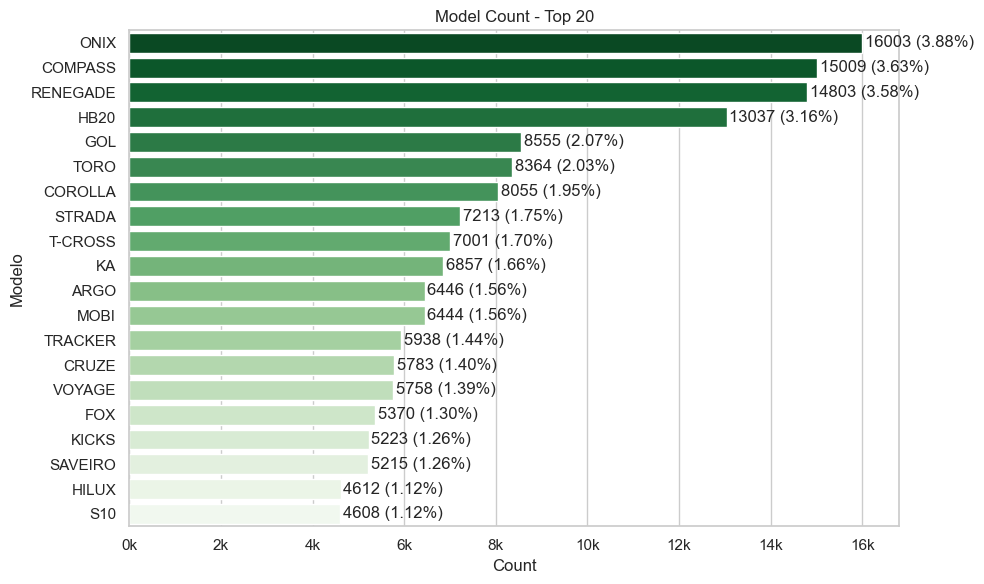

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_count_percentage_horizontal(df1, 'Modelo', 'Model Count - Top 20', ax, top_n=20)
plt.tight_layout()
plt.show()

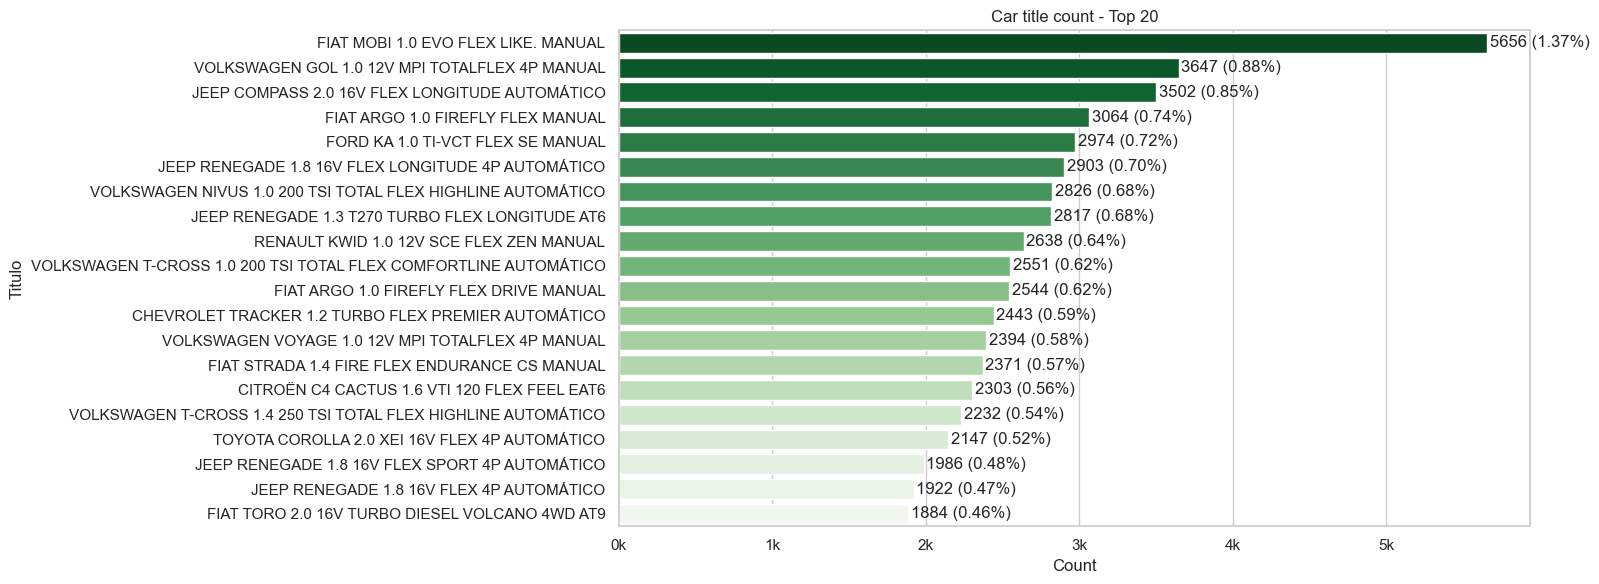

In [26]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_count_percentage_horizontal(df1, 'Titulo', 'Car title count - Top 20', ax, top_n=20)
plt.tight_layout()
plt.show()

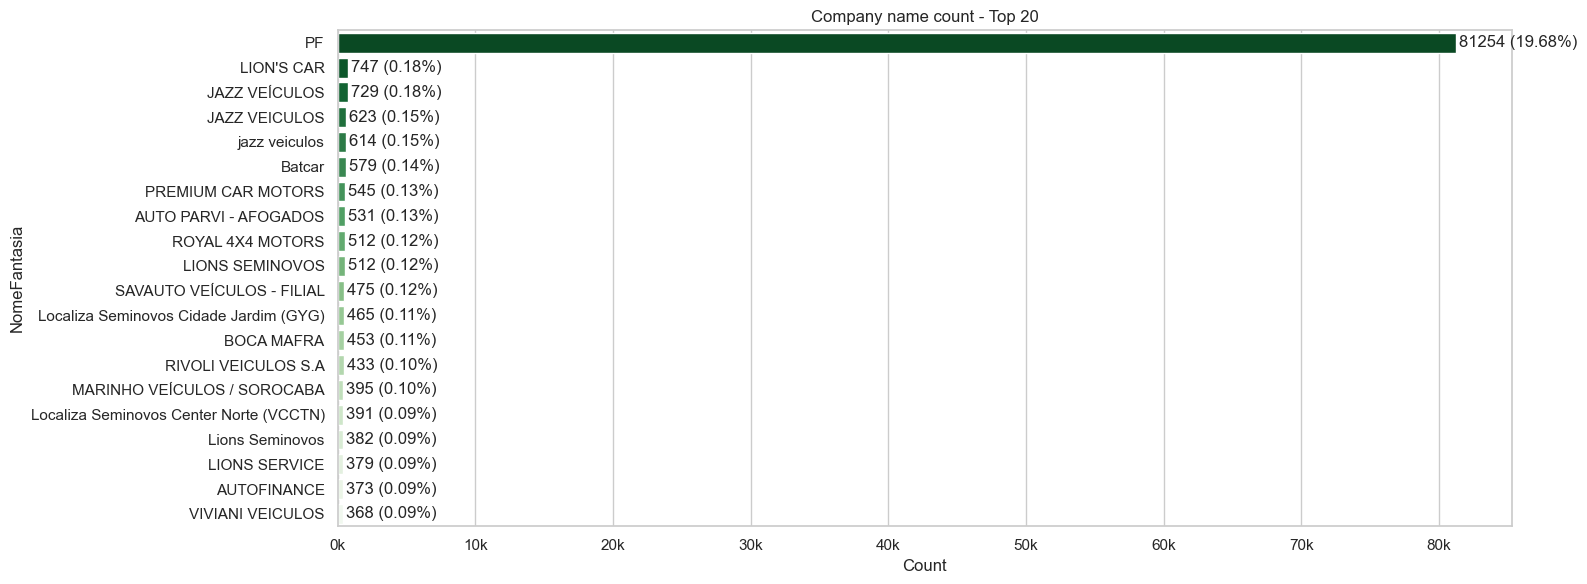

In [27]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_count_percentage_horizontal(df1, 'NomeFantasia', 'Company name count - Top 20', ax, top_n=20)
plt.tight_layout()
plt.show()

# 2.0 - Feature Engineering

In [9]:
df2 = df1.copy()

## 2.1 - Creating hypotesis

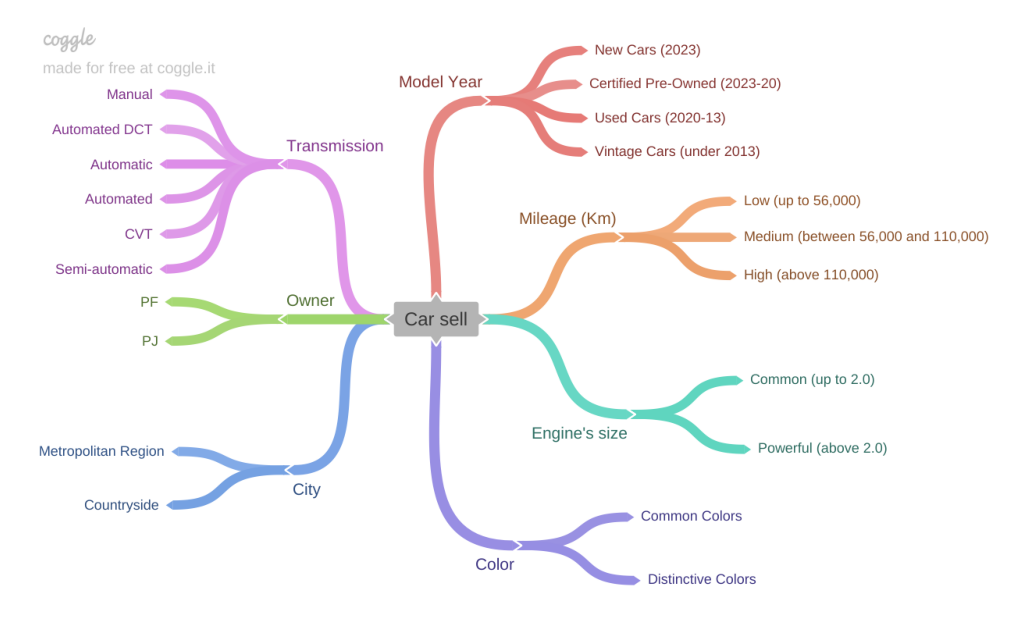

In [10]:
path_to_image = R'C:\Users\gfurt\OneDrive\Documentos\Gabriel\Car_sell_mental_map.png'
from PIL import Image

image = Image.open(path_to_image)
plt.figure(figsize=(16, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

**Hypotesis**

- **H1 - Model Year:** Cars lose 10% of their value for each of the first 10 years of use.
- **H2 - Mileage (KM):** Cars with lower mileage are more expensive than those with higher mileage
- **H3 - Color_2:** Cars in common colors are more expensive than cars in other colors
- **H4 - City:** There are more cars for sale in the top 5 metropolitan cities
- **H5 - Owner:** Cars owned by legal entities (PJ) are more expensive than those owned by individuals (PF)   

## 2.2. Feature Engineering

### 2.2.1. Valor Fipe

In [11]:
# Creating the feature with the car model's value in the FIPE table
df2['Valor Fipe'] = df2['Valor'] / df2['Fipe'] * 100

### 2.2.2. Combustivel

In [12]:
hibrido = df2['Versao'].str.contains(r'HIBRIDO|HYBRID|HEV|PHEV|MHEV|HÍBRIDO', case=False)
df2.loc[hibrido, 'Combustivel'] = 'Hibrido'

eletrico = df2['Versao'].str.contains(r'ELETRICO|ELECTRIC|ELÉTRICO', case=False)
df2.loc[eletrico, 'Combustivel'] = 'Eletrico'

diesel = df2['Versao'].str.contains(r'DIESEL', case=False)
df2.loc[diesel, 'Combustivel'] = 'Diesel'

alcool = df2['Versao'].str.contains(r'ÁLCOOL', case=False)
df2.loc[alcool, 'Combustivel'] = 'Alcool'

flex = df2['Versao'].str.contains(r'FLEX', case=False)
df2.loc[flex, 'Combustivel'] = 'Flex'

gasolina = df2['Versao'].str.contains(r'GASOLINA', case=False)
df2.loc[gasolina, 'Combustivel'] = 'Gasolina'

tetrafuel = df2['Versao'].str.contains(r'TETRAFUEL', case=False)
df2.loc[tetrafuel, 'Combustivel'] = 'Tetrafuel'

### 2.2.3. Cilindrada

In [13]:
# Create a new feature with the engine displacement described in the vehicle version
regex_exp = r'(\d+\.\d+)'
df2['Cilindrada'] = df2['Versao'].str.extract(regex_exp)

In [14]:
# Assign '0' for electric cars
condicao = (df2['Cilindrada'].isna()) | (df2['Cilindrada'] == '')
df2.loc[condicao & eletrico, 'Cilindrada'] = 0

df2['Cilindrada'] = df2['Cilindrada'].astype('float64')

### 2.2.4. Segmenting the cars by year

In [15]:
# Criar um nome para identificar cada versão e ano de cada carro
df2['Marca - Modelo - Versao - Ano'] = df2.apply(lambda row: ' - '.join(map(str, [row['Titulo'], row['AnoModelo']])), axis=1)

# 3.0 - Variable Filtering

In [16]:
df3 = df2.copy()

## 3.1. Row Filtering

### 3.1.1 Filtering missing values 

In [17]:
# Removing rows with missing values in the 'Cilindrada' column
df3 = df3.copy()
df3.dropna(subset=['Cilindrada'], inplace=True)

In [18]:
# Removing rows with missing values in the 'Combustivel' column
df3 = df3.copy()
df3.dropna(subset=['Combustivel'], inplace=True)

### 3.1.2 Filtering outliers in KM

In [19]:
# Removendo KM acima de 888.888 e nos casos abaixo de 300 KM manter somente os carros de 2023, visto que muitos anúncios são realizados com erros na KM

df3 = df3[df3['KM'] < 888888]

df3 = df3[df3['KM'] != 0]

condition_km = df3['KM'] <= 1500
condition_ano = df3['AnoModelo'] < 2024
df3 = df3[~(condition_km & condition_ano)]

In [20]:
df3 = remove_outliers(df3, 'KM')

Número de outliers removidos em KM: 25794


### 3.1.3 Filtering AnoModelo

In [21]:
df3 = remove_outliers(df3, 'AnoModelo')

Número de outliers removidos em AnoModelo: 10043


### 3.1.4 Filtering AnoFabricacao

In [22]:
df3 = remove_outliers(df3, 'AnoFabricacao')

Número de outliers removidos em AnoFabricacao: 6808


### 3.1.5 Filtering duplicate IDs

In [23]:
# Remover todos os anúncios duplicados (provavelmente apareceram mais de uma vez no momento da coleta dos dados devido a anúncio pago pela parte do vendedor)
df3 = df3.drop_duplicates(subset=['UniqueId'], keep='first')

### 3.1.6 Filtering Fipe error

In [24]:
df3 = df3[df3['Fipe'] != 666]

In [25]:
df3 = remove_outliers(df3, 'Fipe')

Número de outliers removidos em Fipe: 35236


### 3.1.7 Filtering Value outliers

In [26]:
df3 = remove_outliers(df3, 'Valor')

Número de outliers removidos em Valor: 34150


### 3.1.8 Filtering Brands

In [27]:
# Remover Marcas com menos de 1% do dataset
df_aux = df3['Marca'].value_counts(normalize = True).reset_index()
df_aux = df_aux[df_aux['proportion'] >= 0.01]
top_marcas = df_aux['Marca']
df3 = df3[df3['Marca'].isin(top_marcas)]

## 3.2. Feature Filtering

In [28]:
# Removing 'Fipe' feature - to prevent data leakage (since this feature displays the percentage that the car's value represents of the FIPE table)
# FIPE tableis a well-known reference used for pricing vehicles

df3 = df3.drop('Fipe', axis=1)

In [29]:
# Removing 'Valor Fipe' Feature
df3 = df3.drop('Valor Fipe', axis=1)

# Study the possibility of including this feature in the next version of the model, since the values from the FIPE table are available on the internet.
# The idea would be to include a step to query the value in the FIPE table before making the value prediction.

In [30]:
# Removing 'Link' Feature
df3 = df3.drop('Link', axis=1)

In [31]:
# Removing 'Titulo' Feature
# df3 = df3.drop('Titulo', axis=1)

In [32]:
# Removing 'Marca - Modelo - Versao - Ano' Feature
df3 = df3.drop('Marca - Modelo - Versao - Ano', axis=1)

In [33]:
# Removing 'NomeFantasia' Feature
df3 = df3.drop('NomeFantasia', axis=1)

# 4.0 - Exploratory Data Analysis

In [34]:
df4 = df3.copy()

In [35]:
# Para colocar o Valor por último
column_names = ['Titulo', 'Marca', 'Modelo', 'Versao', 'AnoFabricacao', 'AnoModelo', 'Estado', 'Cidade', 'KM', 'Cambio', 'NumeroPortas', 'TipoCorpo', 
                'UnicoDono', 'IPVAPago', 'Licenciado', 'Blindado', 'Cor', 'TipoVendedor','TipoAnuncio', 'Combustivel', 'Cilindrada', 'Valor']

df4 = df4[column_names]

## 4.1 - Univaraite Analysis

In [40]:
num_attributes2 = df4.select_dtypes(include = ['int', 'float'])
cat_attributes2 = df4.select_dtypes(exclude = ['int', 'float', 'datetime'])

In [41]:
df4.dtypes

Titulo            object
Marca             object
Modelo            object
Versao            object
AnoFabricacao      int64
AnoModelo          int64
Estado            object
Cidade            object
KM               float64
Cambio            object
NumeroPortas       int64
TipoCorpo         object
UnicoDono           bool
IPVAPago            bool
Licenciado          bool
Blindado          object
Cor               object
TipoVendedor      object
TipoAnuncio       object
Combustivel       object
Cilindrada       float64
Valor            float64
dtype: object

### 4.1.1. Numeric Attributes

In [42]:
descriptive_statistics(num_attributes2)

,attributes,range,media,mediana,std,skew,kurtosis,min,25%,50%,75%,90%,99%,max
0,AnoFabricacao,13.00,"2,018.57","2,019.00",3.11,-0.66,-0.58,"2,011.00","2,017.00","2,019.00","2,021.00","2,022.00","2,023.00","2,024.00"
1,AnoModelo,13.00,"2,019.20","2,020.00",3.14,-0.62,-0.61,"2,011.00","2,017.00","2,020.00","2,022.00","2,023.00","2,023.00","2,024.00"
2,KM,"157,900.00","66,806.20","61,000.00","33,956.98",0.50,-0.32,100.00,"42,553.00","61,000.00","89,000.00","116,700.00","150,000.00","158,000.00"
3,NumeroPortas,4.00,3.82,4.00,0.71,-4.22,17.72,0.00,4.00,4.00,4.00,4.00,4.00,4.00
4,Cilindrada,6.20,1.49,1.50,0.43,0.94,2.62,0.00,1.00,1.50,1.80,2.00,3.00,6.20
5,Valor,"164,900.00","84,288.02","77,000.00","33,327.29",0.73,-0.08,"15,900.00","58,900.00","77,000.00","105,900.00","132,990.00","173,900.00","180,800.00"


Text(0.5, 1.0, 'Valor')

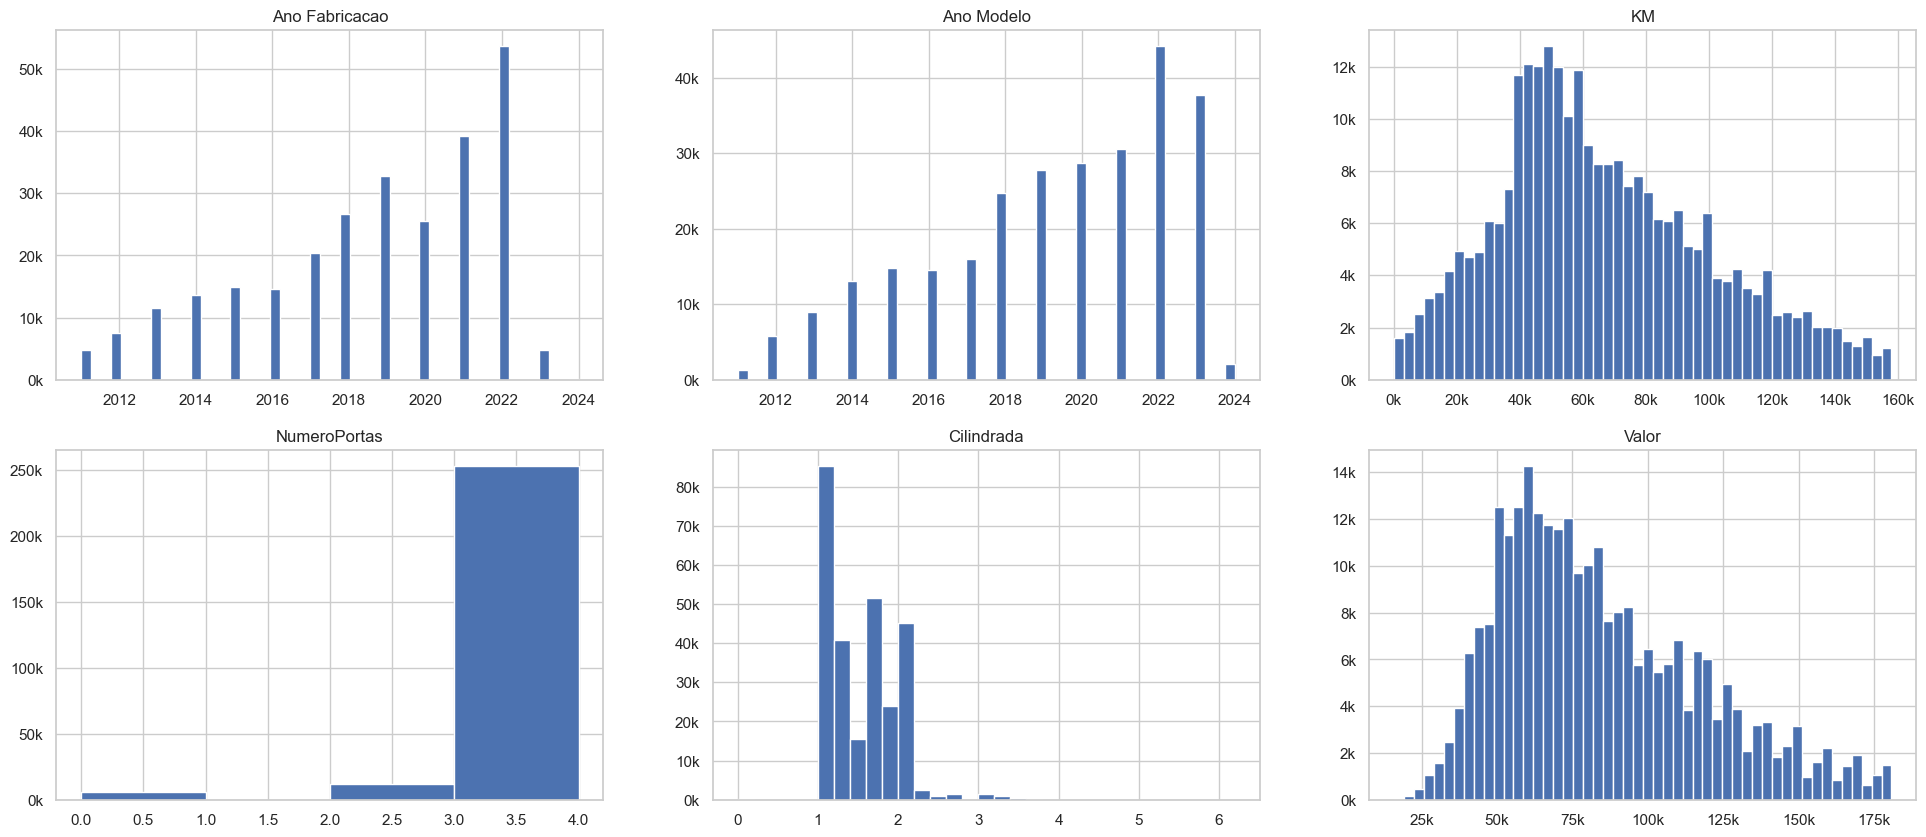

In [43]:
plt.subplot(2, 3, 1)
df4['AnoFabricacao'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Ano Fabricacao")

plt.subplot(2, 3, 2)
df4['AnoModelo'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Ano Modelo")

plt.subplot(2, 3, 3)
df4['KM'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(milhares_x))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("KM")

plt.subplot(2, 3, 4)
df4['NumeroPortas'].hist(bins=len(df4['NumeroPortas'].unique()) , figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("NumeroPortas")

plt.subplot(2, 3, 5)
df4['Cilindrada'].hist(bins= len(df4['Cilindrada'].unique()), figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Cilindrada")

plt.subplot(2, 3, 6)
df4['Valor'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(milhares_x))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Valor")

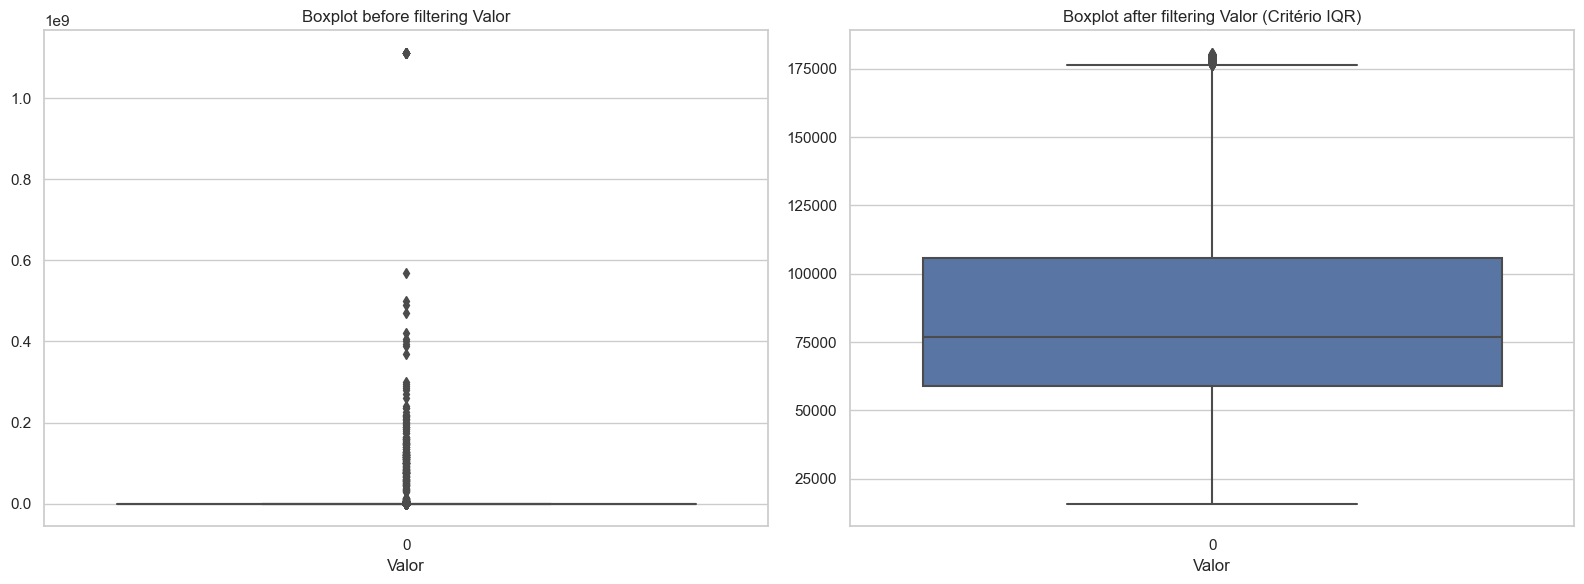

In [44]:
plt.figure(figsize=(16, 6))

# boxplot outliers removido
plt.subplot(1, 2, 1)
sns.boxplot(df2['Valor'])
plt.title('Boxplot before filtering Valor')
plt.xlabel('Valor')

# boxplot outliers removido
plt.subplot(1, 2, 2)
sns.boxplot(df4['Valor'])
plt.title('Boxplot after filtering Valor (Critério IQR)')
plt.xlabel('Valor')

# Mostrar o gráfico
plt.tight_layout()
plt.show()

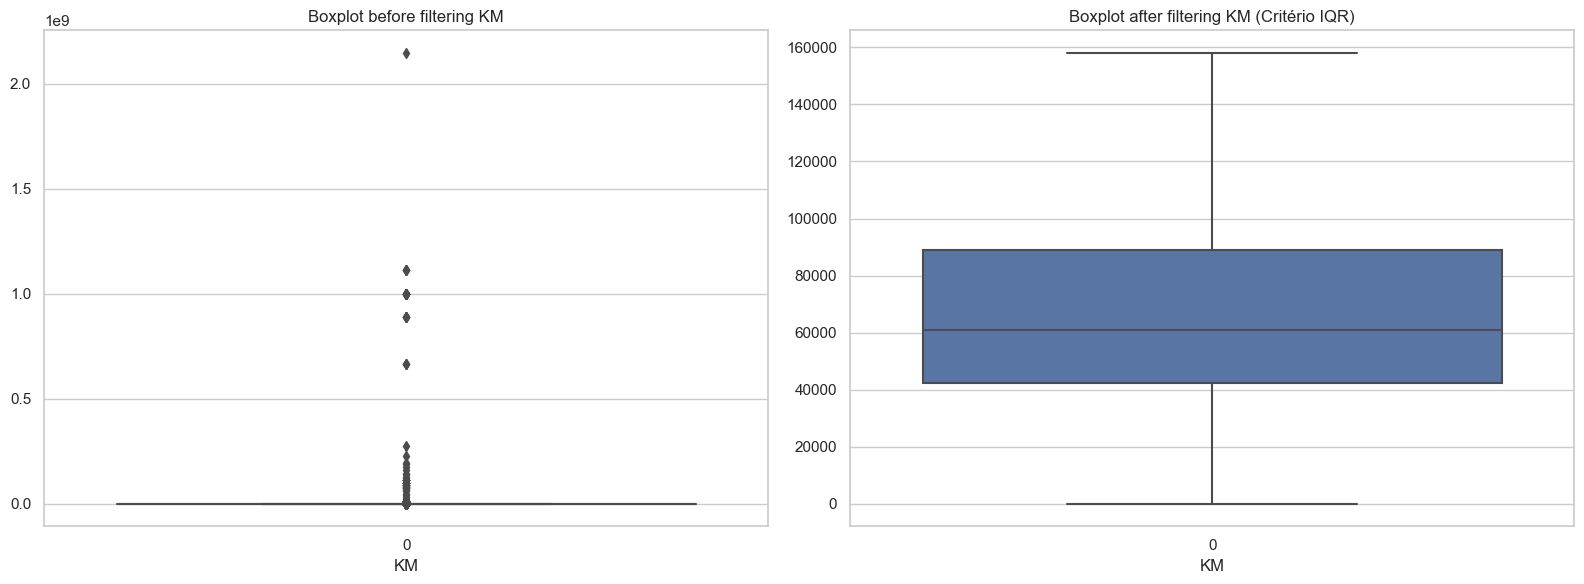

In [45]:
plt.figure(figsize=(16, 6))

# boxplot outliers removido
plt.subplot(1, 2, 1)
sns.boxplot(df2['KM'])
plt.title('Boxplot before filtering KM')
plt.xlabel('KM')

# boxplot outliers removido
plt.subplot(1, 2, 2)
sns.boxplot(df4['KM'])
plt.title('Boxplot after filtering KM (Critério IQR)')
plt.xlabel('KM')

plt.tight_layout()


# Mostrar o gráfico
plt.show()

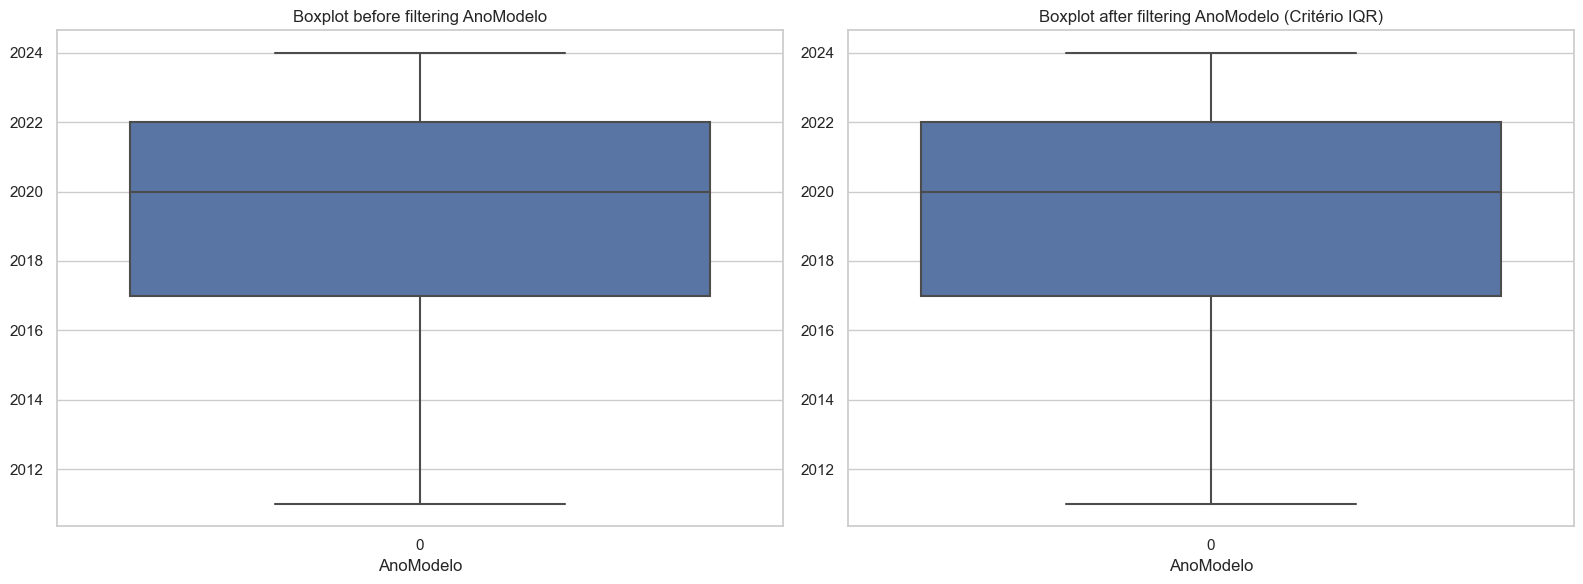

In [46]:
plt.figure(figsize=(16, 6))

# boxplot outliers removido
plt.subplot(1, 2, 1)
sns.boxplot(df3['AnoModelo'])
plt.title('Boxplot before filtering AnoModelo')
plt.xlabel('AnoModelo')

# boxplot outliers removido
plt.subplot(1, 2, 2)
sns.boxplot(df4['AnoModelo'])
plt.title('Boxplot after filtering AnoModelo (Critério IQR)')
plt.xlabel('AnoModelo')

plt.tight_layout()


# Mostrar o gráfico
plt.show()

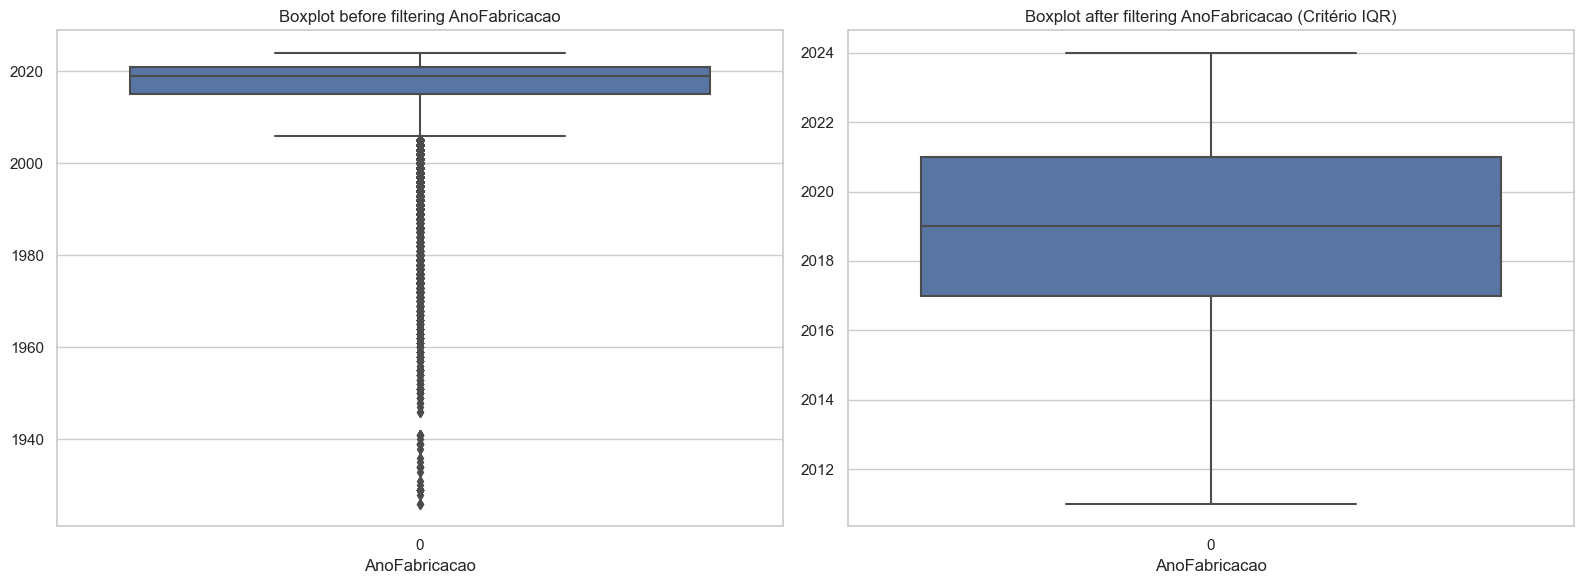

In [47]:
plt.figure(figsize=(16, 6))

# boxplot outliers removido
plt.subplot(1, 2, 1)
sns.boxplot(df2['AnoFabricacao'])
plt.title('Boxplot before filtering AnoFabricacao')
plt.xlabel('AnoFabricacao')

# boxplot outliers removido
plt.subplot(1, 2, 2)
sns.boxplot(df4['AnoFabricacao'])
plt.title('Boxplot after filtering AnoFabricacao (Critério IQR)')
plt.xlabel('AnoFabricacao')

plt.tight_layout()


# Mostrar o gráfico
plt.show()

### 4.1.2. Categorical Attributes

In [48]:
cat_attributes2.describe().T

,count,unique,top,freq
Titulo,270386,2412,FIAT MOBI 1.0 EVO FLEX LIKE. MANUAL,5475
Marca,270386,17,VOLKSWAGEN,43750
Modelo,270386,288,ONIX,14424
Versao,270386,2095,1.0 12V MPI TOTALFLEX 4P MANUAL,5743
Estado,270386,27,São Paulo (SP),117218
Cidade,270386,1504,São Paulo,39998
Cambio,270386,7,Automática,143046
TipoCorpo,270386,9,Utilitário esportivo,95622
UnicoDono,270386,2,False,215630
IPVAPago,270386,2,False,185361


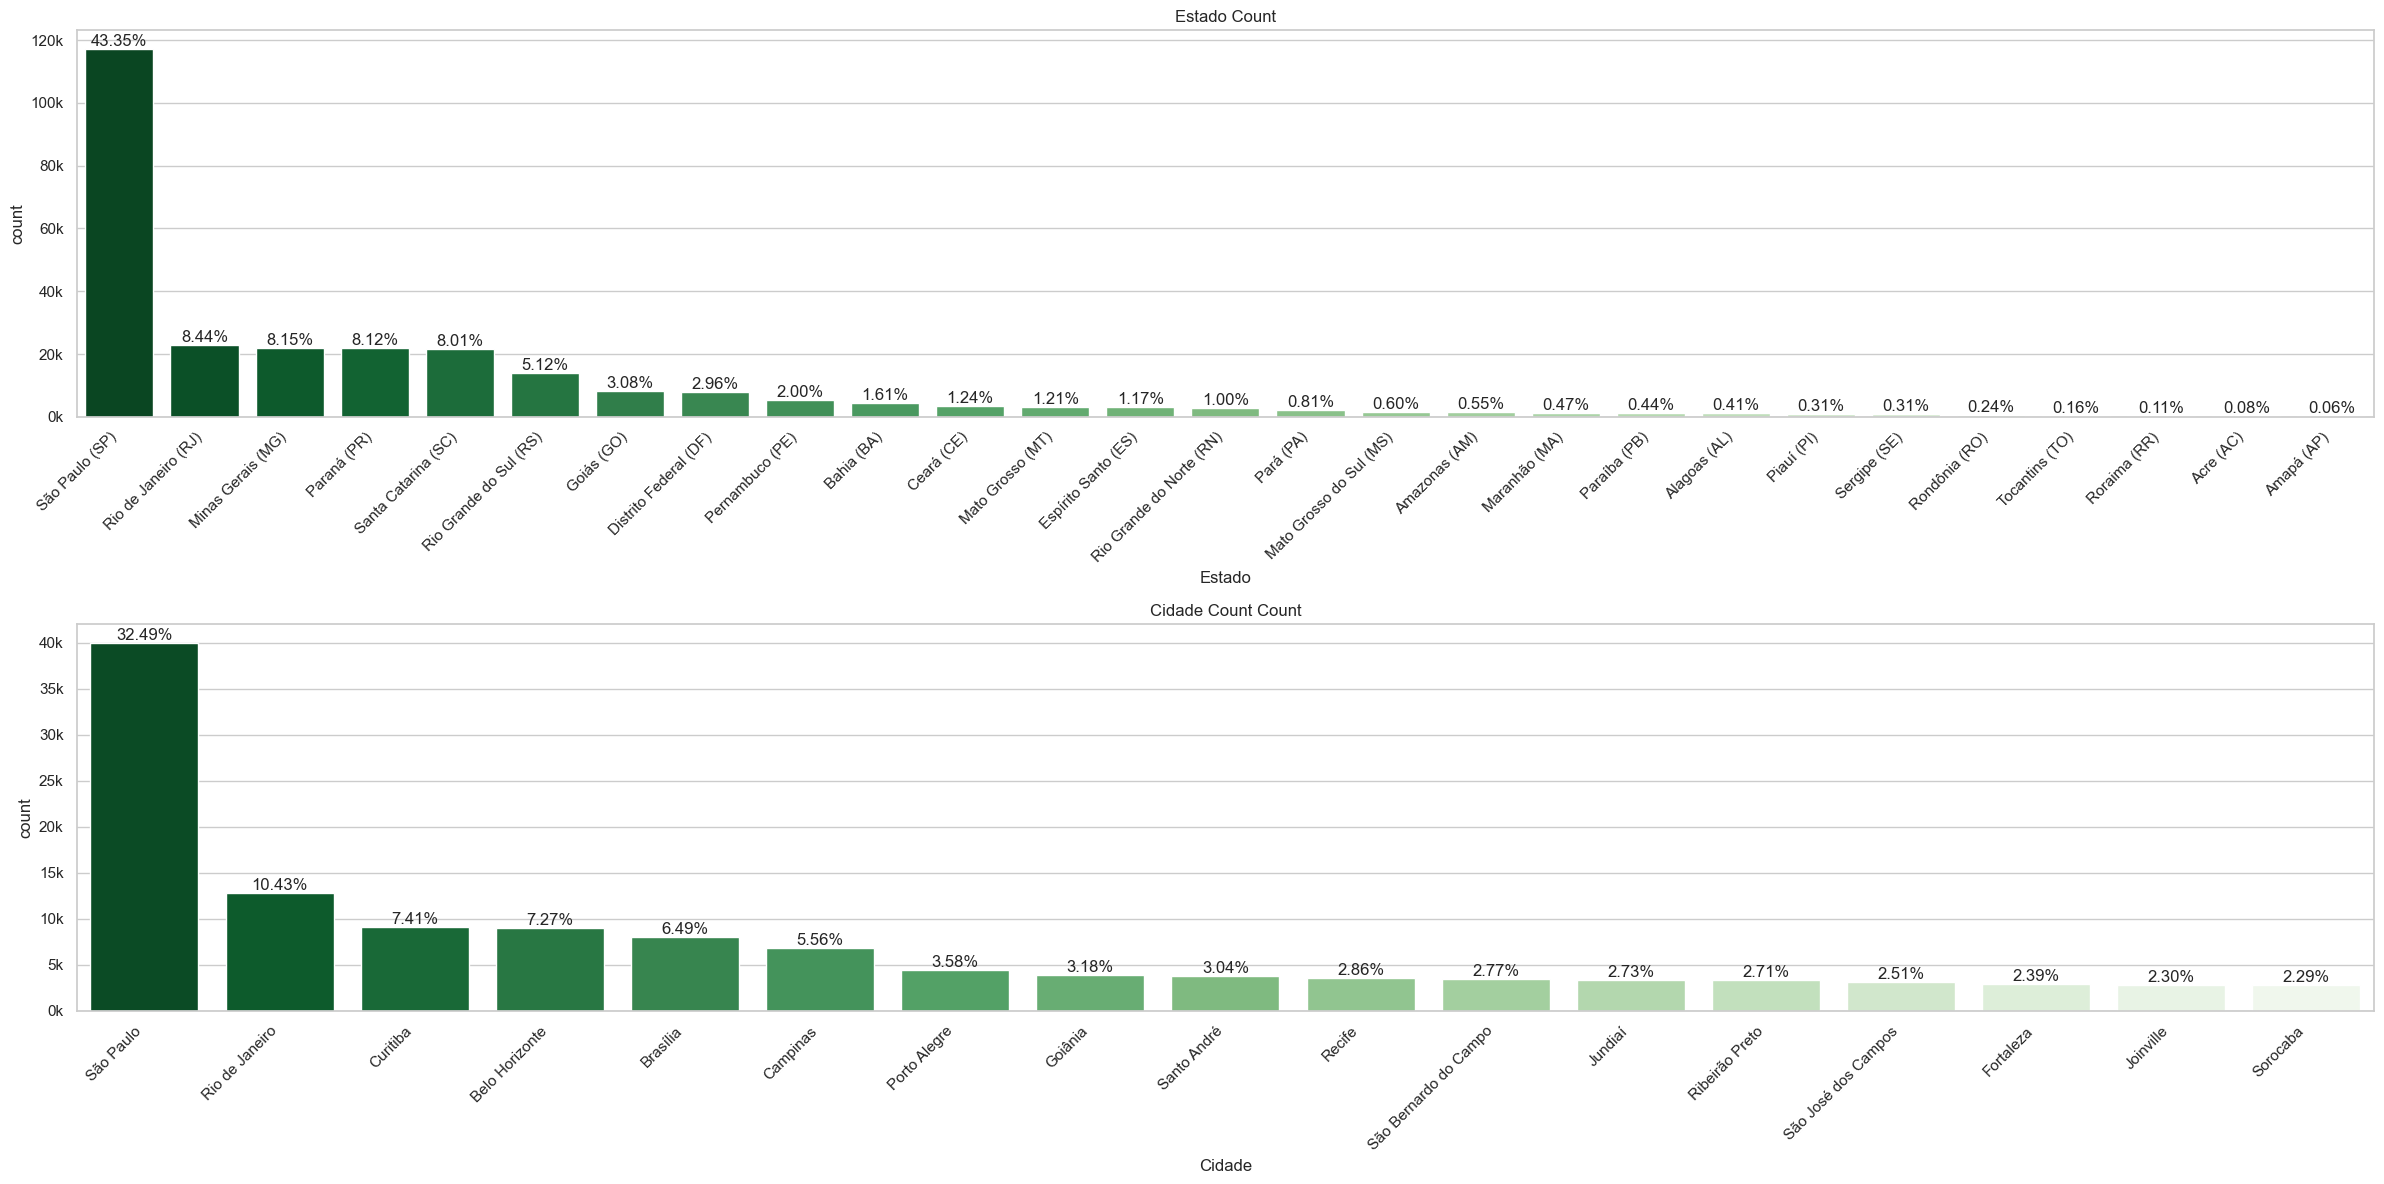

In [49]:
df_aux = df4['Cidade'].value_counts(normalize=True).reset_index()
df_aux = df_aux[df_aux['proportion'] >= 0.01]
top_cidades = df_aux['Cidade']
df_aux2 = df4[df4['Cidade'].isin(top_cidades)]

fig, axs = plt.subplots(2, 1, figsize=(24,12))

plot_count_percentage(df4, 'Estado', 'Estado Count', axs[0], 2, 12)
plot_count_percentage(df_aux2, 'Cidade', 'Cidade Count Count', axs[1], 2, 12)

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
plt.tight_layout()
plt.show()

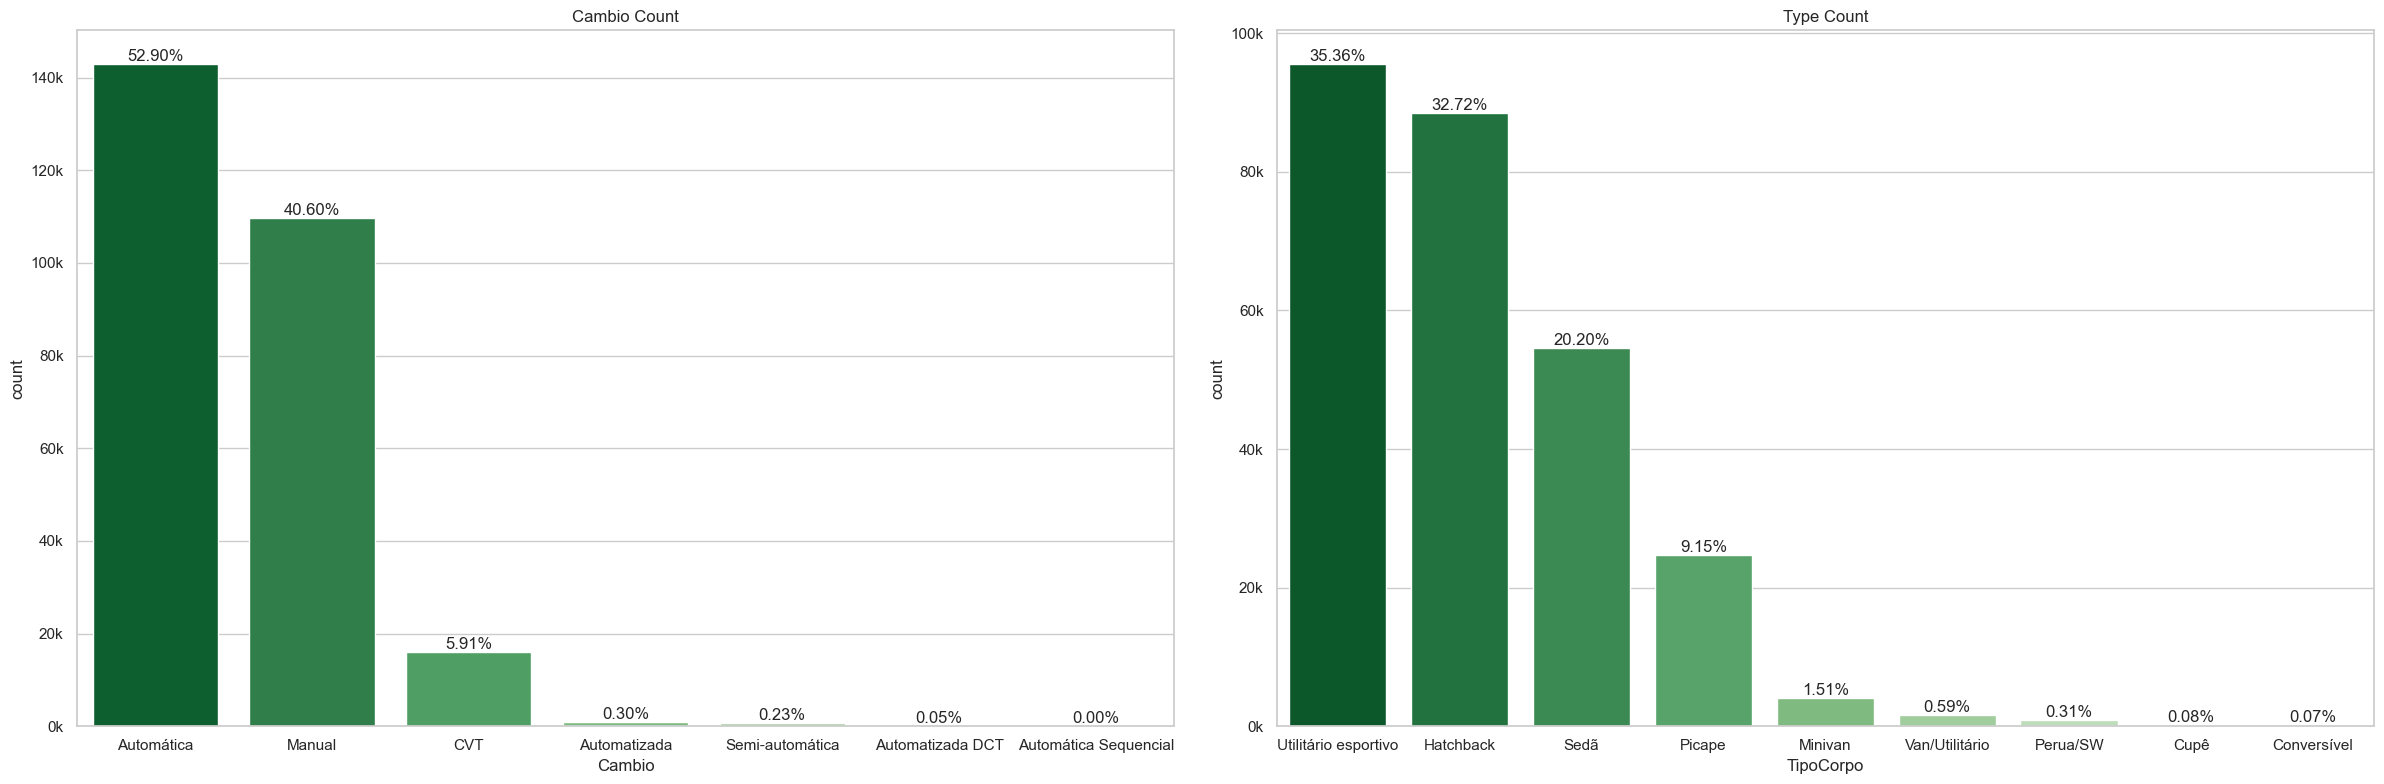

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(24,8))

plot_count_percentage(df4, 'Cambio', 'Cambio Count', axs[0], 2, 12)
plot_count_percentage(df4, 'TipoCorpo', 'Type Count', axs[1], 2, 12)

plt.tight_layout()
plt.show()

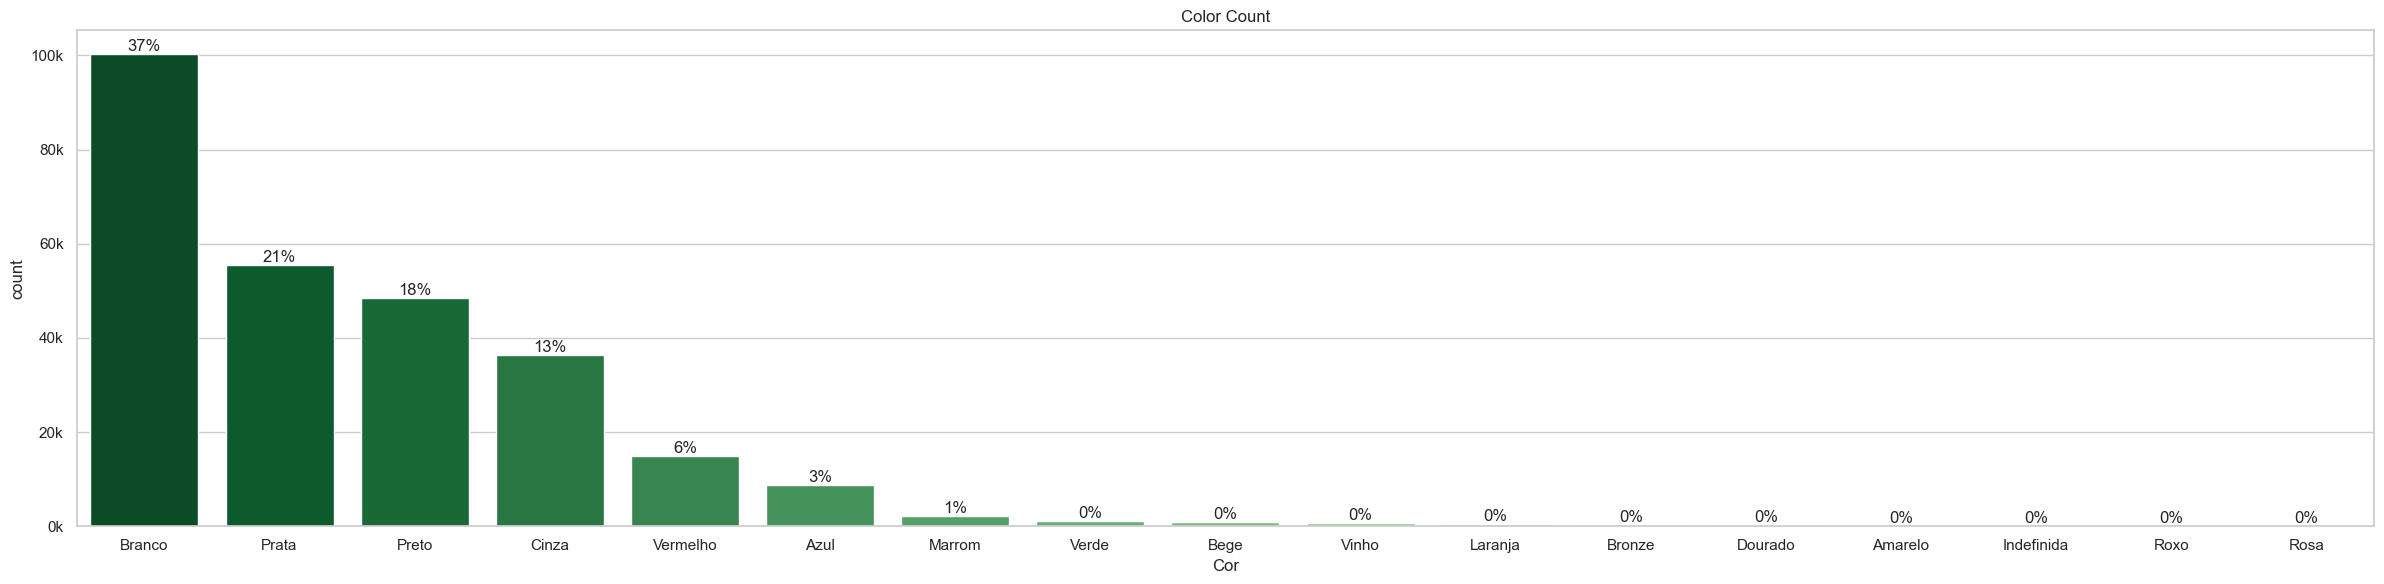

In [51]:
fig, axs = plt.subplots(1, 1, figsize=(24, 6))

plot_count_percentage(df4, 'Cor', 'Color Count', axs, 0, 12)

plt.tight_layout()
plt.show()

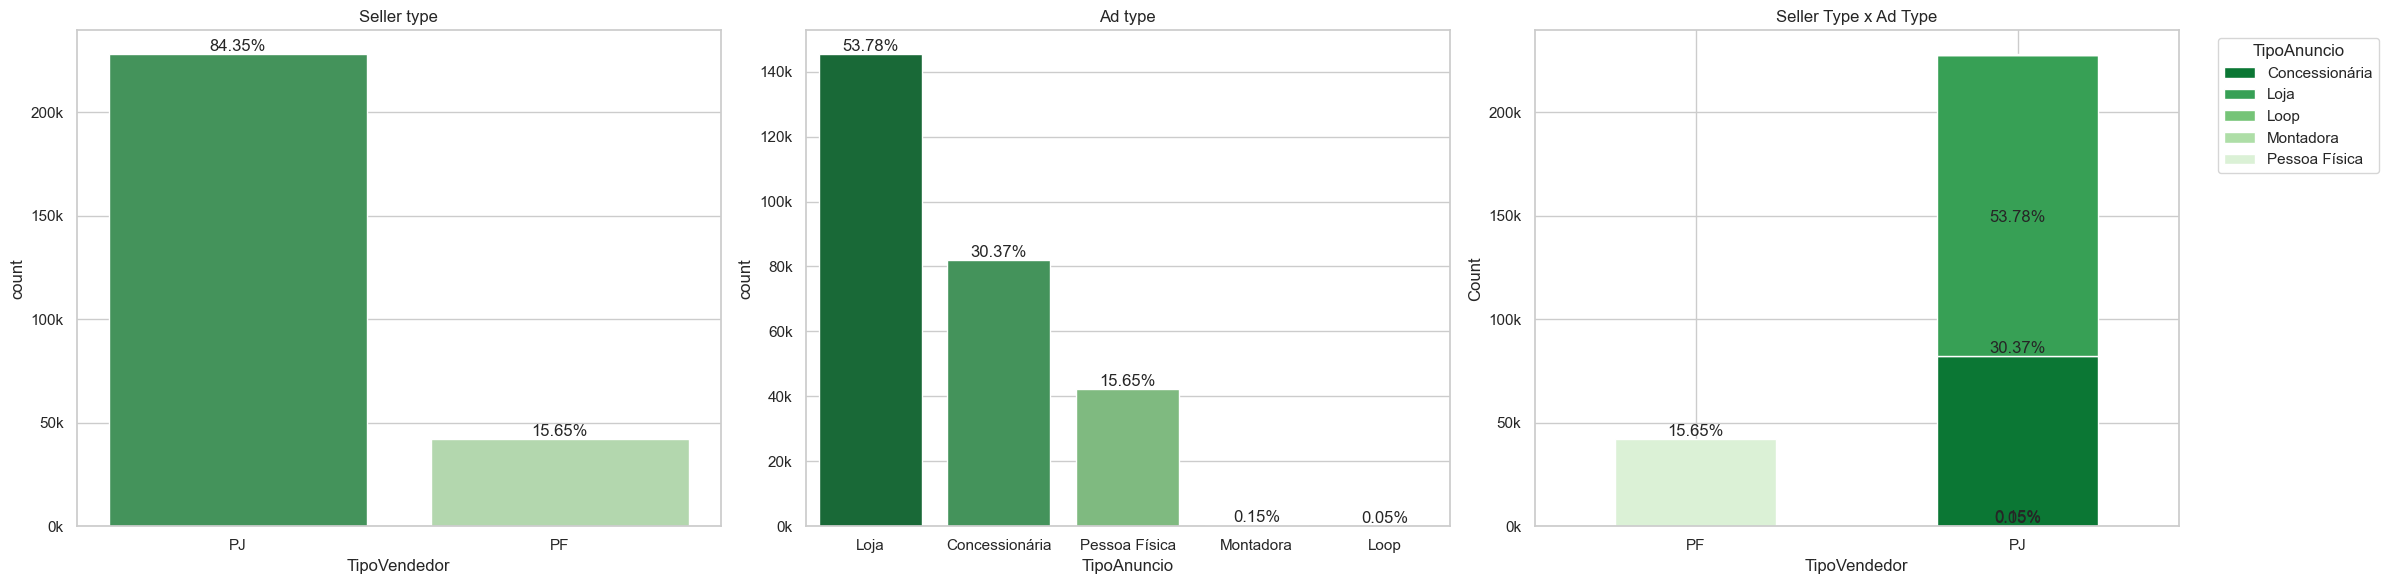

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

plot_count_percentage(df4, 'TipoVendedor', 'Seller type', axs[0], 2, 12)
plot_count_percentage(df4, 'TipoAnuncio', 'Ad type', axs[1], 2, 12)
plot_combined_bar_chart(df4, axs[2], 'Seller Type x Ad Type')

plt.tight_layout()
plt.show()

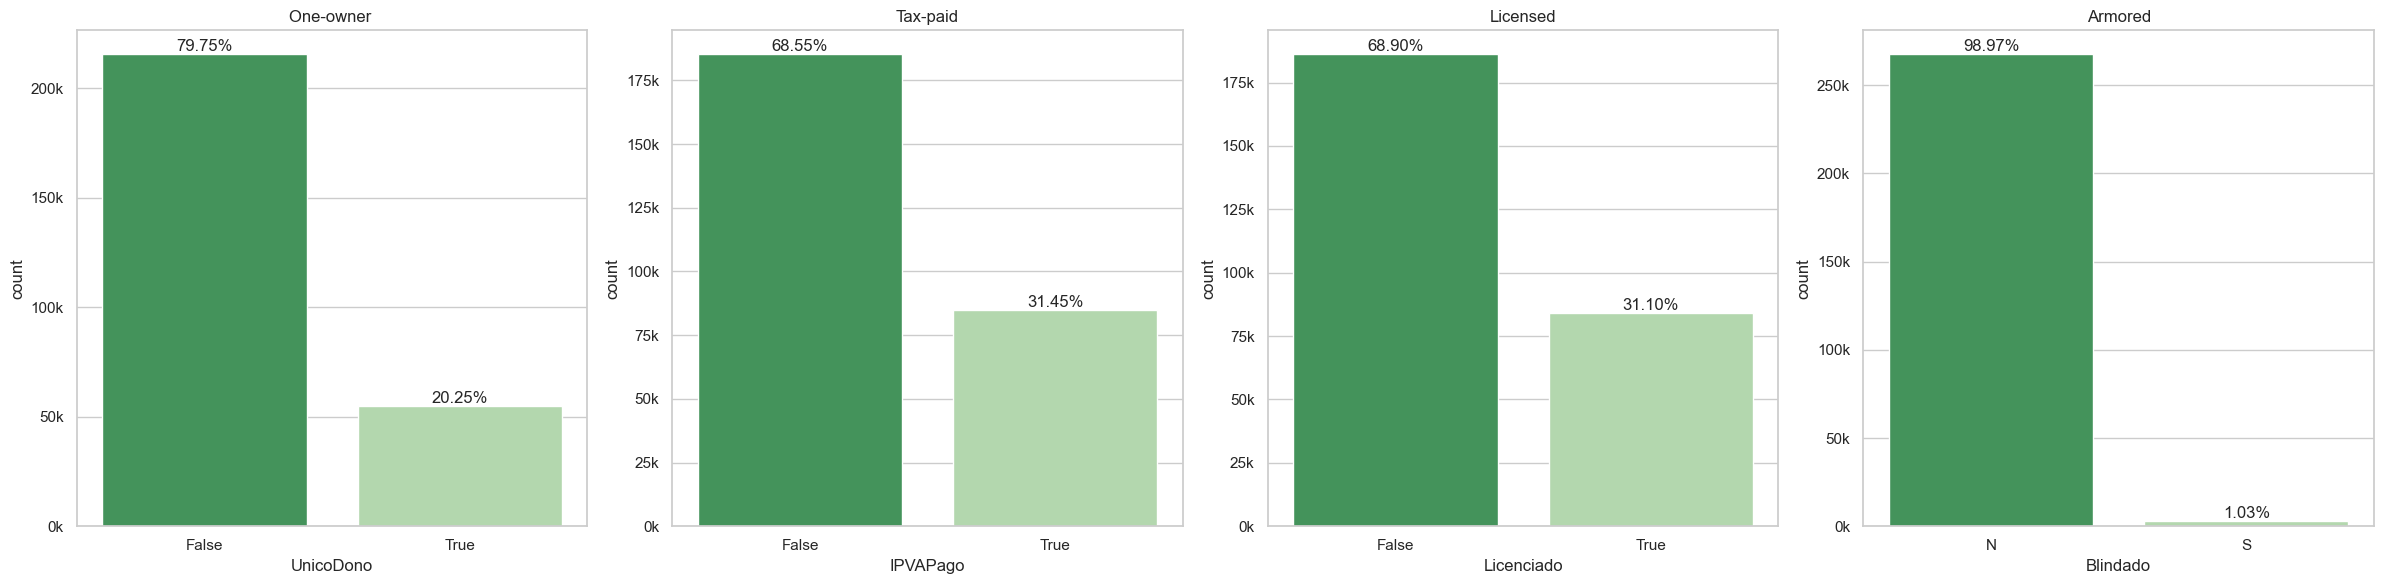

In [53]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

plot_count_percentage(df4, 'UnicoDono', 'One-owner ', axs[0], 2, 12)
plot_count_percentage(df4, 'IPVAPago', 'Tax-paid', axs[1], 2, 12)
plot_count_percentage(df4, 'Licenciado', 'Licensed', axs[2], 2, 12)
plot_count_percentage(df4, 'Blindado', 'Armored', axs[3], 2, 12)
plt.tight_layout()
plt.show()

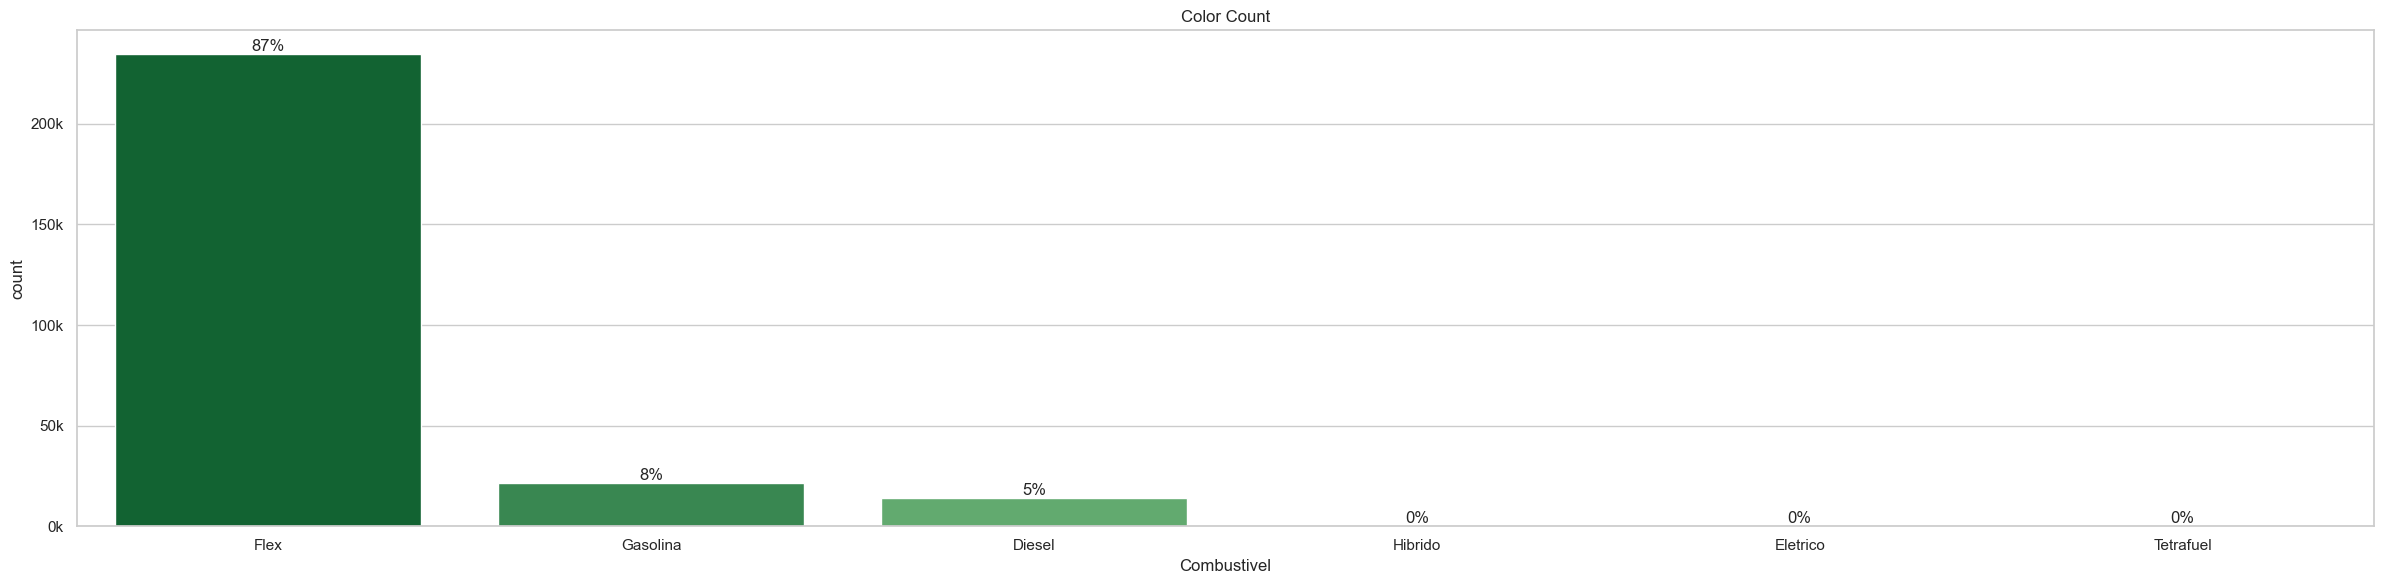

In [54]:
fig, axs = plt.subplots(1, 1, figsize=(24, 6))

plot_count_percentage(df4, 'Combustivel', 'Color Count', axs, 0, 12)

plt.tight_layout()
plt.show()

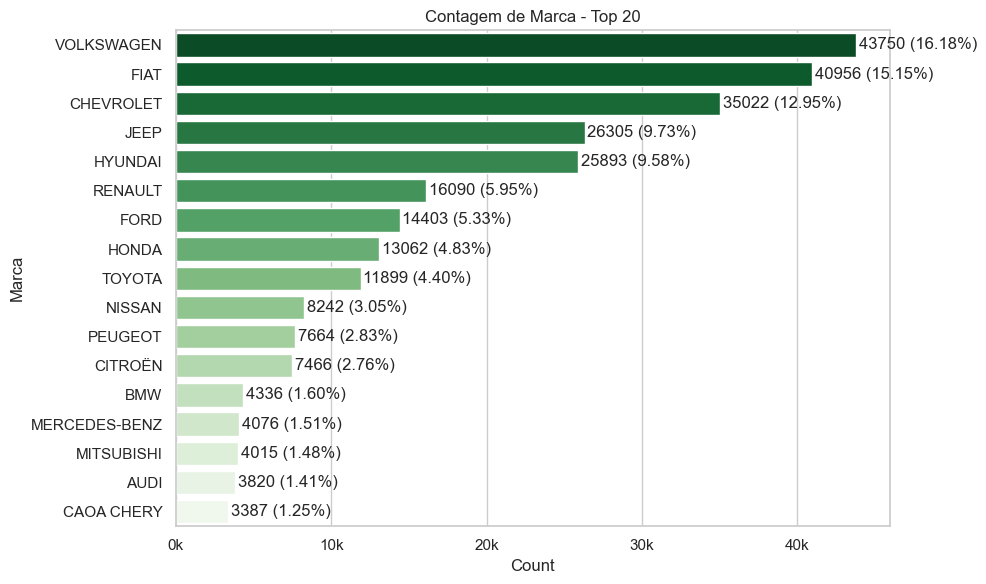

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_count_percentage_horizontal(df4, 'Marca', 'Contagem de Marca - Top 20', ax, top_n=20)
plt.tight_layout()
plt.show()

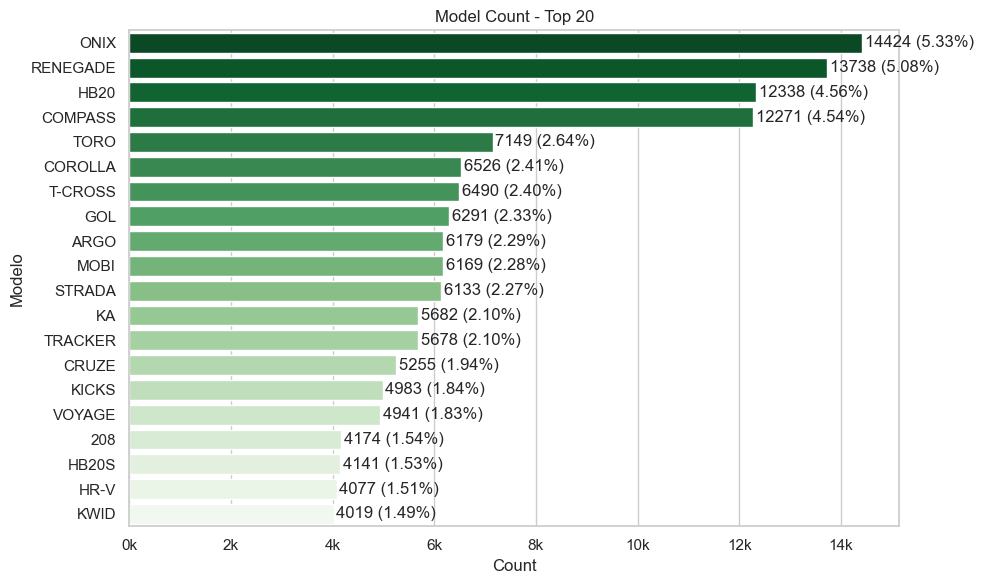

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_count_percentage_horizontal(df4, 'Modelo', 'Model Count - Top 20', ax, top_n=20)
plt.tight_layout()
plt.show()

## 4.2 - Bivaraite Analysis

**Hypotesis**

- **H1 - Model Year:** Cars lose 10% of their value for each of the first 10 years of use.
- **H2 - Mileage (KM):** Cars with lower mileage are more expensive than those with higher mileage
- **H3 - Color_2:** Cars in common colors are more expensive than cars in other colors
- **H4 - City:** There are more cars for sale in the top 5 metropolitan cities
- **H5 - Owner:** Cars owned by legal entities (PJ) are more expensive than those owned by individuals (PF)

### 4.2.1. H1 - Model Year: Cars lose 10% of their value for each of the first 10 years of use: <span style="color:Red">False</span>

In [57]:
df_aux = df4[df4['AnoModelo'] >= 2013]
df_mean_valor = df_aux.groupby(['Marca', 'Modelo', 'Versao', 'AnoModelo'])['Valor'].mean().reset_index()
df_mean_valor['Marca - Modelo - Versao'] = df_mean_valor.apply(lambda row: ' - '.join(map(str, [row['Marca'], row['Modelo'], row['Versao']])), axis=1)
df_mean_valor = df_mean_valor.sort_values(by=['Marca - Modelo - Versao', 'AnoModelo'], ascending=[True, False])
df_mean_valor['Diferenca_Ano_Modelo'] = df_mean_valor.groupby('Marca - Modelo - Versao')['AnoModelo'].transform(lambda x: x.diff())
df_mean_valor['Diferenca_Valor'] = df_mean_valor.groupby('Marca - Modelo - Versao')['Valor'].transform(lambda x: x.diff())
df_mean_valor['Variation'] = (((df_mean_valor['Valor'] / (df_mean_valor['Valor'] + df_mean_valor['Diferenca_Valor'])  ) ** (1/df_mean_valor['Diferenca_Ano_Modelo'])) -1 ) * 100

In [58]:
df_mean_valor_dropna = df_mean_valor.dropna(subset=['Variation']).copy()
df_aux = df_mean_valor_dropna.groupby('Marca - Modelo - Versao')['Variation'].mean().reset_index()
df_aux['Variation'].mean()

-7.30763321187823

#### The average annual depreciation is 8.03%, approximately 20% below the expected value

PS: According to the data collected from cars advertised on WebMotors

### 4.2.2. H2 - Cars with lower mileage are more expensive than those with higher mileage: <span style="color:green">True</span>

In [59]:
df_aux = df4.copy()
df_aux['Marca - Modelo - Versao - Ano'] = df_aux.apply(lambda row: ' - '.join(map(str, [row['Marca'], row['Modelo'], row['Versao'], row['AnoModelo']])), axis=1)
df_aux = df_aux[['Marca - Modelo - Versao - Ano', 'KM', 'Valor']]
df_aux = df_aux.sort_values(by=['Marca - Modelo - Versao - Ano', 'KM'], ascending=[True, False]).reset_index()
df_aux['Diferenca_Valor'] = df_aux.groupby('Marca - Modelo - Versao - Ano')['Valor'].transform(lambda x: x.diff())

df_aux.head()

,index,Marca - Modelo - Versao - Ano,KM,Valor,Diferenca_Valor
0,132885,AUDI - A1 - 1.4 TFSI ATTRACTION 16V 122CV GASO...,"152,000.00","56,900.00",NaN
1,47169,AUDI - A1 - 1.4 TFSI ATTRACTION 16V 122CV GASO...,"140,267.00","53,890.00","-3,010.00"
2,110973,AUDI - A1 - 1.4 TFSI ATTRACTION 16V 122CV GASO...,"140,000.00","58,000.00","4,110.00"
3,67990,AUDI - A1 - 1.4 TFSI ATTRACTION 16V 122CV GASO...,"134,431.00","59,900.00","1,900.00"
4,117718,AUDI - A1 - 1.4 TFSI ATTRACTION 16V 122CV GASO...,"134,000.00","59,777.00",-123.00


In [60]:
df_aux2 = df_aux.groupby(['Marca - Modelo - Versao - Ano'])['Diferenca_Valor'].mean().reset_index()
df_aux2['Diferenca_Valor_Pos'] = df_aux2['Diferenca_Valor'].apply(lambda x: 'Positiva' if x > 0 else 'Não Positiva')
pd.DataFrame(df_aux2['Diferenca_Valor_Pos'].value_counts(normalize=True)*100).reset_index()

,Diferenca_Valor_Pos,proportion
0,Positiva,57.56
1,Não Positiva,42.44


In [61]:
round(df_aux2['Diferenca_Valor'].mean(),2)

181.29

#### 62% of the analyzed cars confirmed that the lower the mileage, the higher the car's value, while 38% recorded a lower price (contrary to the hypothesis). 

We can also identify a positive average variation of R\$1,189.05

indicating that the price difference between two cars of the same version and year is positive, by R$ 1,189.05, when compared to another with lower mileage.

Therefore, even though the relationship is not very strong, the hypothesis proves to be true.


PS: According to the data collected from cars advertised on WebMotors.

### 4.2.3. H3 - Color: Cars in common colors are more expensive than cars in other colors: <span style="color:Green">True</span>

Establishing that the most common car colors are black, white, and silver, we compare the total number of cars advertised in these colors against those in other colors.

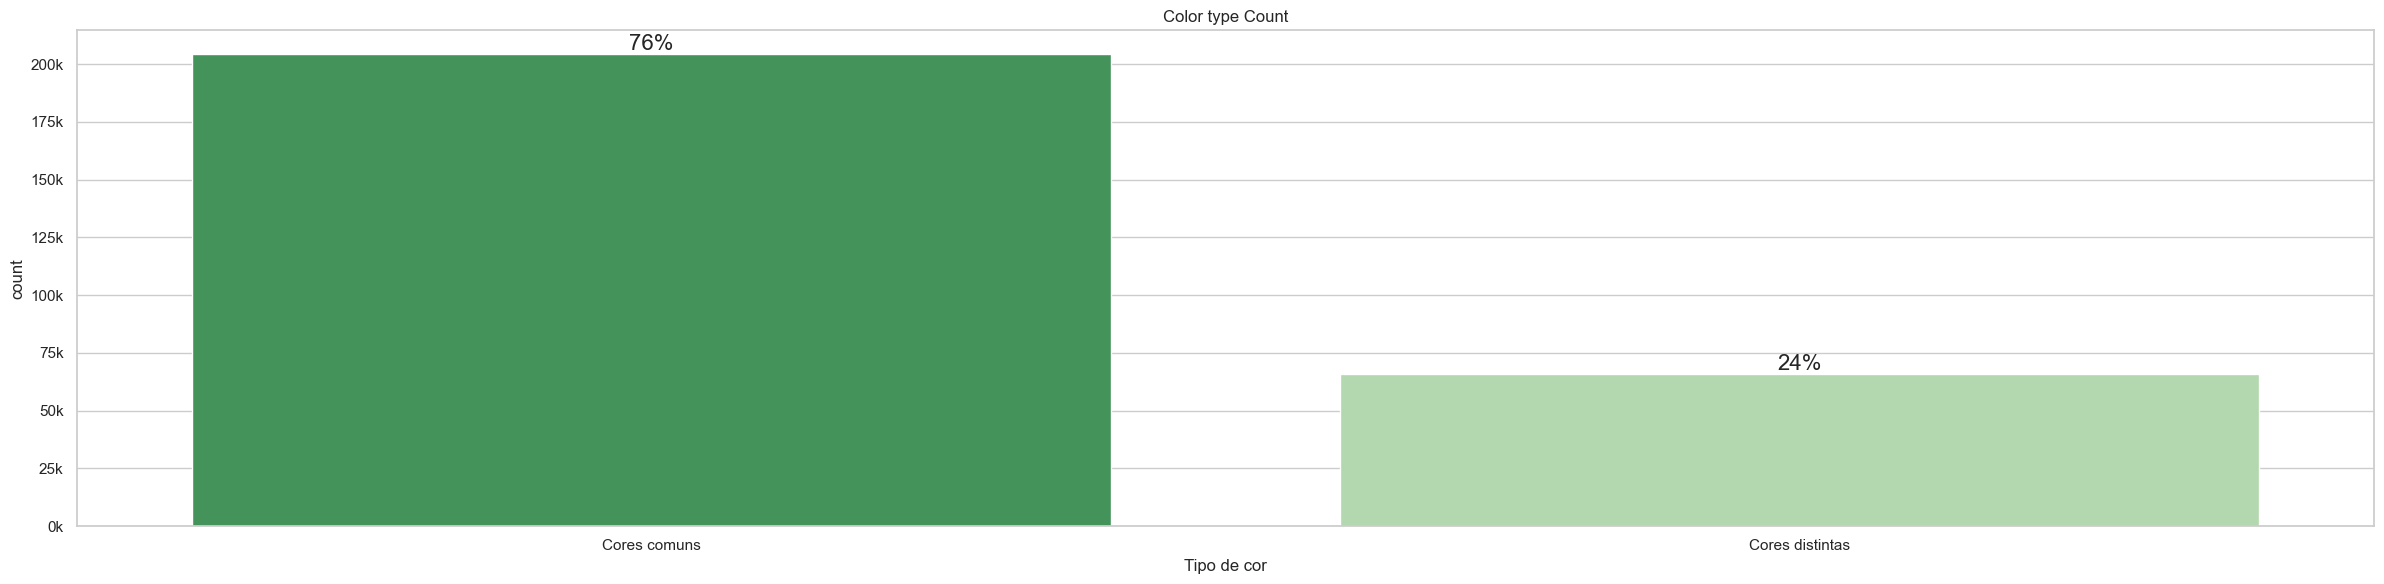

In [62]:
df_aux = df4.copy()

cores_comuns = ['Prata', 'Preto', 'Branco']
df_aux['Tipo de cor'] = df_aux['Cor'].apply(lambda x: 'Cores comuns' if x in cores_comuns else 'Cores distintas')

fig, axs = plt.subplots(1, 1, figsize=(24, 6))

plot_count_percentage(df_aux, 'Tipo de cor', 'Color type Count', axs, 0, 16)

plt.tight_layout()
plt.show()

As shown, **75%** of the advertised cars are in the colors black, white, and silver, with only 25% in different colors.

### 4.2.4. H4 - City: There are more cars for sale in the top 5 metropolitan cities: <span style="color:Green">True</span>

Top 5 cidades metropolitanas do brasil:
- São Paulo
- Rio de Janeiro
- Belo Horizonte
- Porto Alegre
- Recife

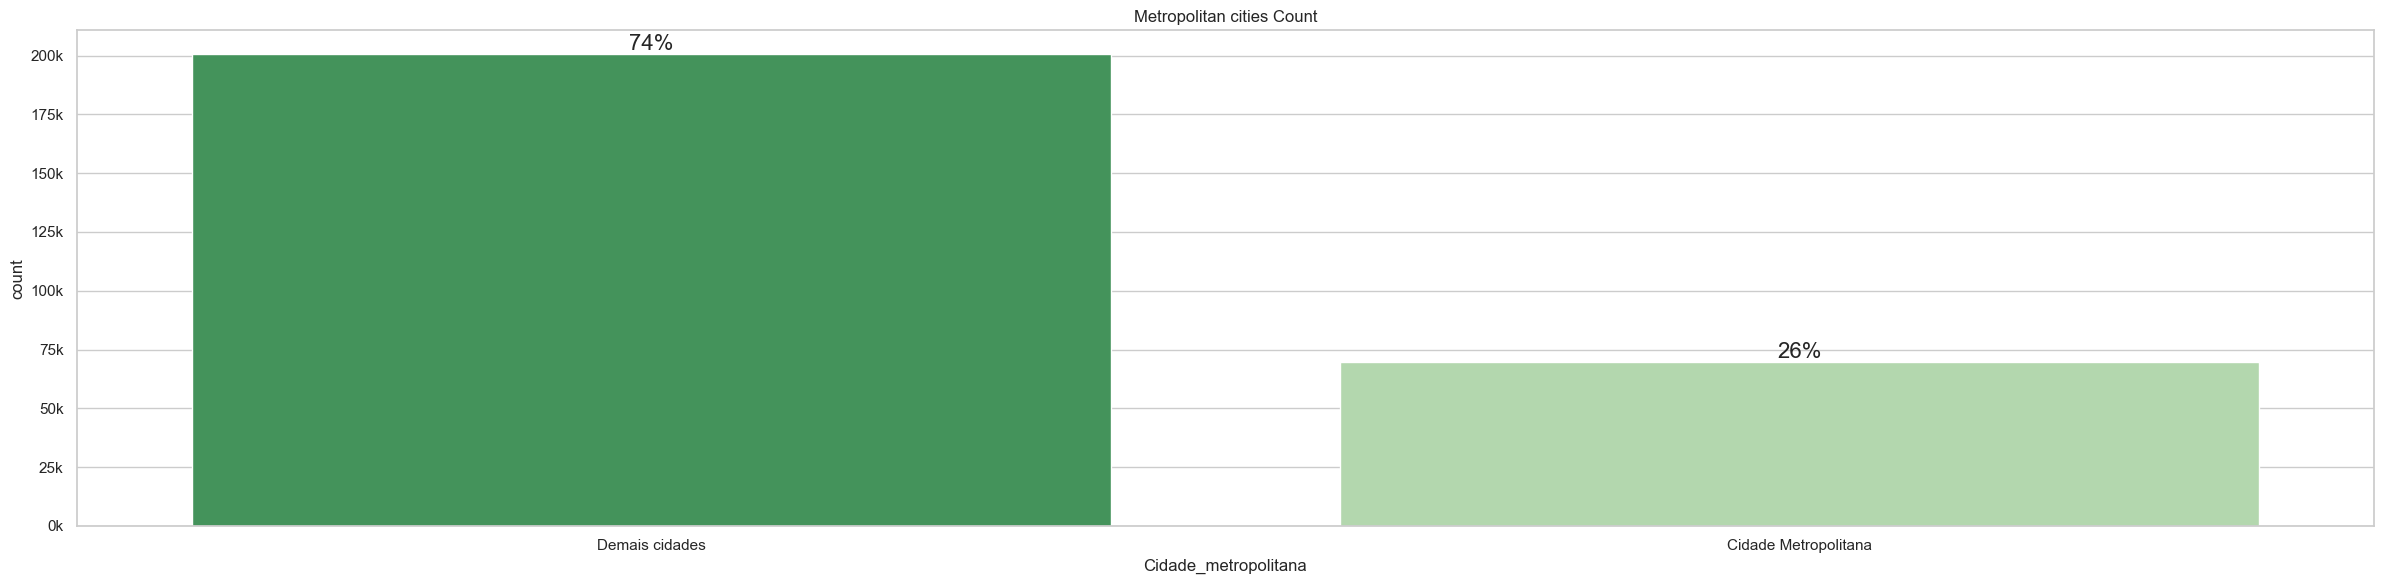

In [63]:
df_aux = df4.copy()
top_5_cidades  = ['São Paulo', 'Rio de Janeiro', 'Belo Horizonte', 'Porto Alegre', 'Recife']

df_aux['Cidade_metropolitana'] = df_aux['Cidade'].apply(lambda x: 'Cidade Metropolitana' if x in top_5_cidades else 'Demais cidades')

fig, axs = plt.subplots(1, 1, figsize=(24, 6))

plot_count_percentage(df_aux, 'Cidade_metropolitana', 'Metropolitan cities Count', axs, 0, 16)

plt.tight_layout()
plt.show()

As shown, 74% of the cars are advertised in one of the top 5 metropolitan cities mentioned above.

### 4.2.5. H5 - Owner: Cars owned by legal entities (PJ) are more expensive than those owned by individuals (PF): <span style="color:Red">False</span>

Para realizar essa comparação, foram identificados os carros de mesma versão e ano sendo vendidos tanto por PF como por PJ, para assim comparar o preço. Desconsiderando todos os demais atributos que alteram o preço dos carros.

In [64]:
df_aux = df4.copy()
df_aux['Marca - Modelo - Versao - Ano'] = df_aux.apply(lambda row: ' - '.join(map(str, [row['Marca'], row['Modelo'], row['Versao'], row['AnoModelo']])), axis=1)

tabela_comparativa = pd.pivot_table(df_aux, index='Marca - Modelo - Versao - Ano', columns='TipoVendedor', aggfunc='size', fill_value=0)
tabela_comparativa['Disponibilidade'] = tabela_comparativa.apply(lambda row: 'Ambos' if row['PF'] > 0 and row['PJ'] > 0 else 'Apenas PF' if row['PF'] > 0 else 'Apenas PJ' if row['PJ'] > 0 else 'Nenhum', axis=1)

df_aux2 = tabela_comparativa[tabela_comparativa['Disponibilidade'] == 'Ambos'].reset_index()
carros_vendidos_por_PFePJ = df_aux['Marca - Modelo - Versao - Ano'].unique()

df_aux3 = df_aux[df_aux['Marca - Modelo - Versao - Ano'].isin(carros_vendidos_por_PFePJ)].groupby(['Marca - Modelo - Versao - Ano', 'TipoVendedor'])['Valor'].mean().reset_index()
mean_values = df_aux3.groupby(['Marca - Modelo - Versao - Ano', 'TipoVendedor'])['Valor'].mean().unstack().reset_index()

In [65]:
mean_values.dropna(subset=['PF'], inplace=True)
mean_values.dropna(subset=['PJ'], inplace=True)

In [66]:
mean_values['Maior_Valor'] = mean_values[['PF', 'PJ']].idxmax(axis=1)
mean_values['Variation'] = ((mean_values['PJ'] / mean_values['PF']) - 1 ) * 100

In [67]:
mean_values['Maior_Valor'].value_counts(normalize=True)

Maior_Valor
PJ   0.81
PF   0.19
Name: proportion, dtype: float64

In [68]:
mean_values['Variation'].mean()

3.5645312027418687

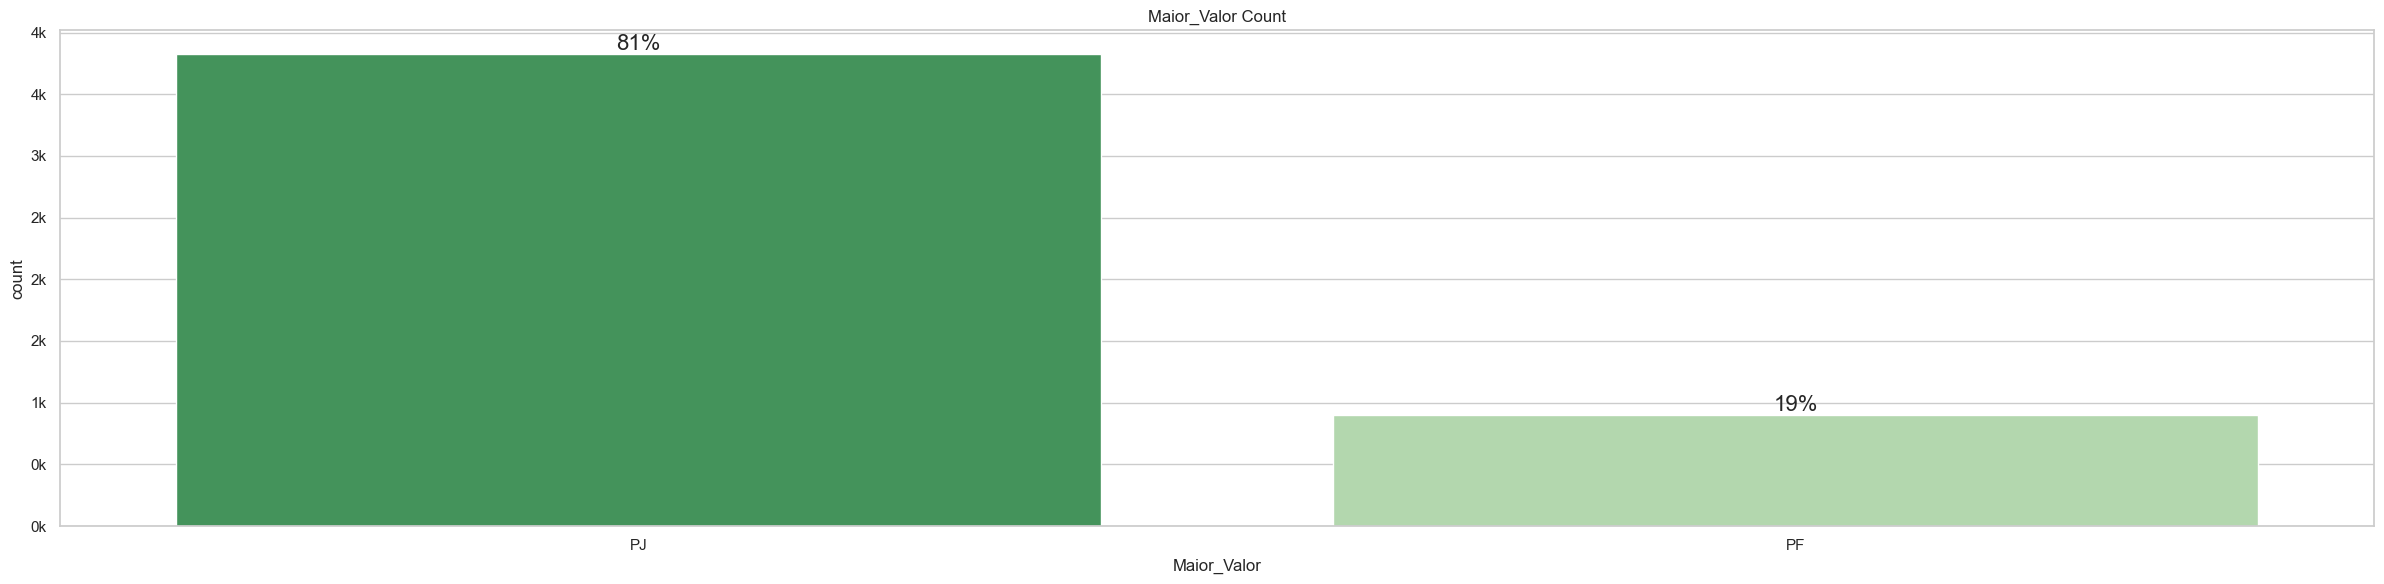

In [69]:
df_aux = df4.copy()

fig, axs = plt.subplots(1, 1, figsize=(24, 6))

plot_count_percentage(mean_values, 'Maior_Valor', 'Maior_Valor Count', axs, 0, 16)

plt.tight_layout()
plt.show()

Como mostra o gráfico, quando comparado o preço médio dos carros anunciados por pessoas físicas contra os de pessoas jurídicas, 78% dos casos o valor é maior para as PJ, com uma média de 5,44%

## 4.2 - Multivaraite Analysis

### 4.2.1. Numerical Attributes

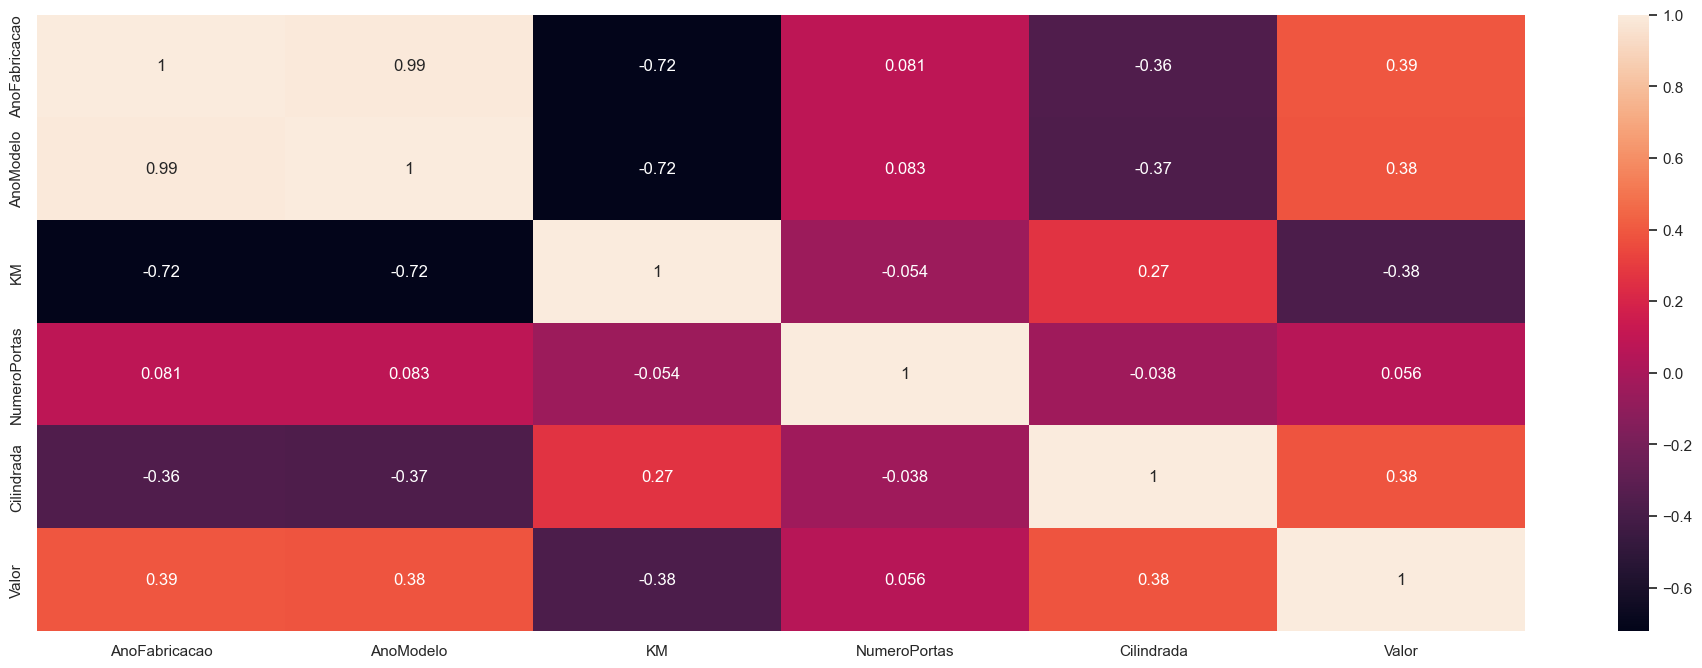

In [70]:
correlation = num_attributes2.corr(method='pearson')
plt.figure(figsize=(24, 8))
sns.heatmap(correlation, annot=True)
plt.show()

Vale lembrar que o ano de fabricação não é levado em consideração, mas, sim, o ano do modelo. Entre os carros envolvidos na pesquisa são excluídos táxis, viaturas, veículos de frota e outros que não se enquadrem no uso comum.

### 4.2.2. Categorical Attributes

In [71]:
cramers_matrix = pd.DataFrame(index=cat_attributes2.columns, columns=cat_attributes2.columns)

for i in cat_attributes2.columns:
    for j in cat_attributes2.columns:
        cramers_matrix.loc[i, j] = cramers_v(cat_attributes2[i], cat_attributes2[j])

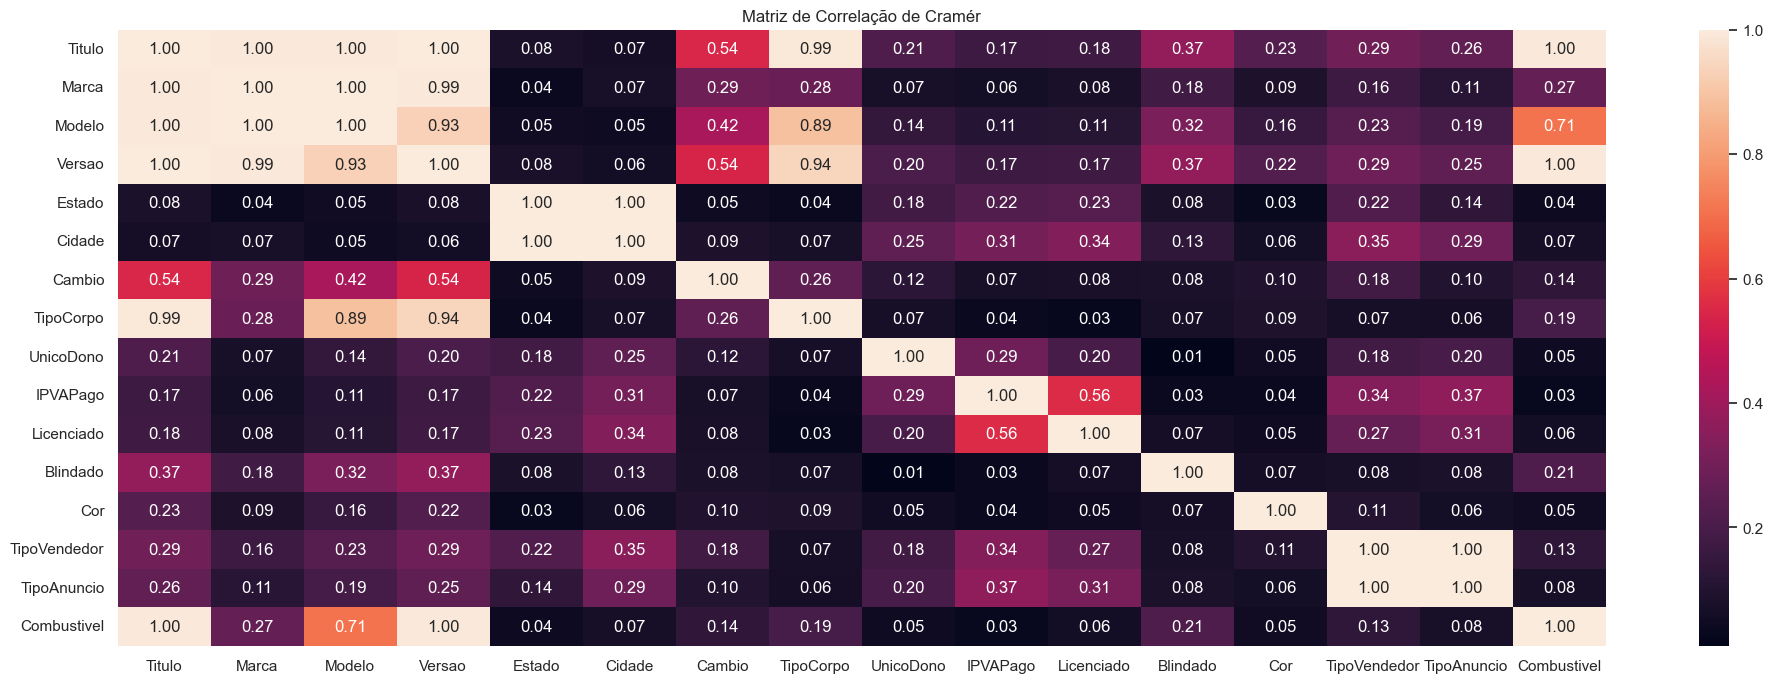

In [72]:
cramers_matrix = cramers_matrix.astype(float)

# Aumentar o tamanho da figura
plt.figure(figsize=(24, 8))

# Criar o mapa de calor com Seaborn
sns.heatmap(cramers_matrix, annot=True, fmt=".2f")

# Adicionar título ao mapa de calor
plt.title("Matriz de Correlação de Cramér")

# Exibir o gráfico
plt.show()

# 5.0 - Data Preparation

In [70]:
df5 = df4.copy()

## 5.1. Rescaling

In [71]:
features = ['AnoFabricacao', 'AnoModelo', 'NumeroPortas', 'Cilindrada']

for feature in features:
    mms = MinMaxScaler()
    df5[feature] = mms.fit_transform(df5[[feature]].values)
    pickle.dump(mms, open(fr'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\{feature}_scaler.pkl', 'wb'))

In [72]:
rs = RobustScaler()

df5['KM'] = rs.fit_transform(df5[['KM']].values)
pickle.dump(rs, open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\KM_scaler.pkl', 'wb'))

## 5.2. Encoding

In [73]:
le_marca = LabelEncoder()
df_raw2 = df_raw.copy()
df_raw2['Marca'] = le_marca.fit_transform(df_raw['Marca'])

le_modelo = LabelEncoder()
df_raw2['Modelo'] = df_raw.groupby('Marca')['Modelo'].transform(lambda x: le_modelo.fit_transform(x))

le_versao = LabelEncoder()
df_raw2['Versao'] = df_raw.groupby(['Marca', 'Modelo'])['Versao'].transform(lambda x: le_versao.fit_transform(x))

df_aux1 = df_raw[['Marca', 'Modelo', 'Versao']].copy()
df_aux2 = df_raw2[['Marca', 'Modelo', 'Versao']].copy()
df_aux2.rename(columns={'Marca': 'Marca_encoded', 'Modelo': 'Modelo_encoded', 'Versao': 'Versao_encoded'}, inplace=True)
df_combined = pd.concat([df_aux1, df_aux2], axis=1)
nova_ordem = ['Marca', 'Marca_encoded', 'Modelo', 'Modelo_encoded', 'Versao', 'Versao_encoded']
df_combined = df_combined[nova_ordem]

df_combined['id'] = df_combined['Marca'].astype(str) + '_' + df_combined['Modelo'].astype(str) + '_' + df_combined['Versao'].astype(str)
df_sem_duplicatas = df_combined.drop_duplicates(subset=['id'], keep='first')
df_encoding = df_sem_duplicatas[nova_ordem]

mapeamento_versao = df_encoding.set_index(['Marca', 'Modelo', 'Versao'])['Versao_encoded'].to_dict()
df5['Versao'] = df5[['Marca', 'Modelo', 'Versao']].apply(lambda x: mapeamento_versao.get(tuple(x), x[2]), axis=1)

mapeamento_modelo = df_encoding.set_index(['Marca', 'Modelo'])['Modelo_encoded'].to_dict()
df5['Modelo'] = df5[['Marca', 'Modelo']].apply(lambda x: mapeamento_modelo.get(tuple(x), x[1]), axis=1)

mapeamento_marca = df_encoding.set_index('Marca')['Marca_encoded'].to_dict()
df5['Marca'] = df5['Marca'].map(mapeamento_marca)

In [74]:
categorical_features = ['Titulo', 'Estado', 'Cidade', 'Cambio', 'TipoCorpo', 'UnicoDono', 'IPVAPago', 'Licenciado', 'Blindado', 'Cor', 'TipoVendedor', 'TipoAnuncio', 'Combustivel']

for feature in categorical_features:
    le = LabelEncoder()
    df5[feature] = le.fit_transform(df5[feature])
    pickle.dump(le, open(fr'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\{feature}_scaler.pkl', 'wb'))

## 5.3. Response Variable Transformation

In [75]:
df5['Valor'] = np.log1p(df5['Valor'])

# 6.0. Feature Selection

In [42]:
df6 = df5.copy()

In [43]:
X_train = df6.drop(columns=['Valor'], axis=1)
y_train = df6['Valor']

## 6.1. REF (Recursive Feature Elimination)

In [759]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
selected_features

Index(['AnoFabricacao', 'AnoModelo', 'KM', 'Cambio', 'TipoCorpo', 'IPVAPago',
       'Blindado', 'TipoVendedor', 'TipoAnuncio', 'Cilindrada'],
      dtype='object')

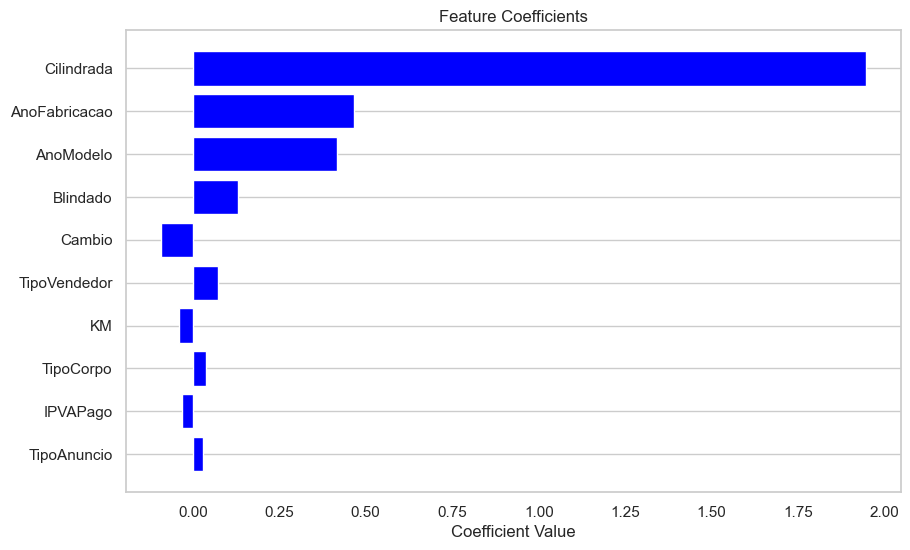

In [760]:
# Criar um novo modelo apenas com as features selecionadas
model_selected_features = LinearRegression()
model_selected_features.fit(X_train[selected_features], y_train)

coefficients = model_selected_features.coef_
selected_features_info = pd.DataFrame({'Feature': selected_features, 'Coefficient': coefficients})
selected_features_info['Absolute_Coefficient'] = selected_features_info['Coefficient'].abs()
sorted_features_info = selected_features_info.sort_values(by='Absolute_Coefficient', ascending=False)

# Plotar um gráfico
plt.figure(figsize=(10, 6))
plt.barh(sorted_features_info['Feature'], sorted_features_info['Coefficient'], color='blue')
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients')
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

## 6.2. Xgboost selector

<Figure size 1000x600 with 0 Axes>

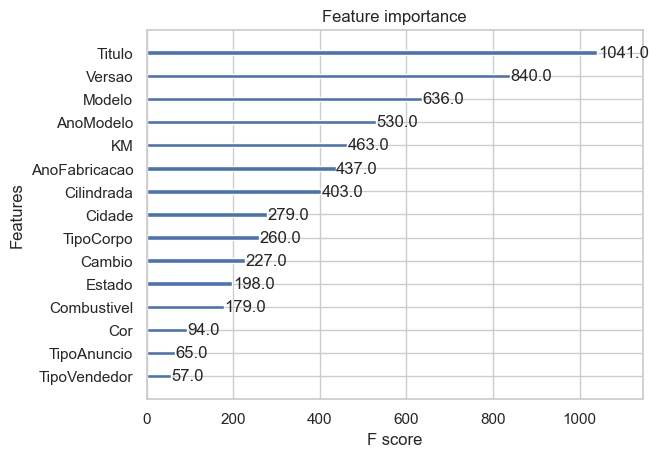

In [761]:
# Supondo que você tenha os conjuntos de treino X_train e y_train
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

# Plotar as importâncias das features
plt.figure(figsize=(10, 6))
plot_importance(model_xgb, importance_type='weight', max_num_features=15)  # Pode ajustar max_num_features conforme necessário
plt.show()


In [762]:
['AnoModelo', 'NumeroPortas', 'TipoCorpo', 'UnicoDono','IPVAPago', 'Licenciado', 'TipoVendedor', 'TipoAnuncio', 'Combustivel', 'Cilindrada']

['AnoModelo',
 'NumeroPortas',
 'TipoCorpo',
 'UnicoDono',
 'IPVAPago',
 'Licenciado',
 'TipoVendedor',
 'TipoAnuncio',
 'Combustivel',
 'Cilindrada']

## 6.3. Lasso Feature selection

In [763]:
lasso_model = Lasso(alpha=0.01) 
lasso_model.fit(X_train, y_train)

lasso_coef = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lasso_model.coef_})

lasso_coef_sorted = lasso_coef.iloc[np.abs(lasso_coef['Coefficient']).argsort()[::-1]]
lasso_coef_sorted.head(10)

,Feature,Coefficient
4,AnoFabricacao,0.21
5,AnoModelo,0.16
9,Cambio,-0.11
8,KM,-0.07
11,TipoCorpo,0.06
19,Combustivel,-0.05
1,Marca,0.00
16,Cor,-0.00
2,Modelo,0.00
0,Titulo,-0.00


## 6.4. Selected features

In [122]:
# Apesar dos testes feitos acima, segui com uma seleção manual com base nas correlações analisadas na eta da análise exploratória e o resultado dos algoritmos realizados em testes com diferentes combinações de features

# 7.0. Machine Learning Model

In [44]:
df7 = df6.copy()

In [45]:
X = df7.drop(columns=['Titulo', 'Valor'])
y = df7['Valor']

## 7.1. Linear Regression

In [100]:
# Model
lr_model = LinearRegression()

# Metrics
scoring = {'MAE': make_scorer(lambda y, yhat: mean_absolute_error(np.expm1(y), np.expm1(yhat))),
           'MAPE': make_scorer(lambda y, yhat: np.mean(np.abs((np.expm1(y) - np.expm1(yhat)) / np.expm1(y)))),
           'RMSE': make_scorer(lambda y, yhat: np.sqrt(mean_squared_error(np.expm1(y), np.expm1(yhat))))}

# Corss Validation
cv_lr_result = cross_validate(lr_model, X, y, scoring=scoring, cv=5, return_train_score=False)

lr_results_df = pd.DataFrame({'Model Name': 'Linear Regression',
    'MAE': cv_lr_result['test_MAE'].mean(),
    'MAPE': cv_lr_result['test_MAPE'].mean(),
    'RMSE': cv_lr_result['test_RMSE'].mean()
}, index=['Média'])
lr_results_df

,Model Name,MAE,MAPE,RMSE
Média,Linear Regression,"13,719.84",0.16,"19,181.10"


## 7.2. Ridge Regression

In [768]:
# Model
ridge_model = Ridge()

# Metrics
scoring = {'MAE': make_scorer(lambda y, yhat: mean_absolute_error(np.expm1(y), np.expm1(yhat))),
           'MAPE': make_scorer(lambda y, yhat: np.mean(np.abs((np.expm1(y) - np.expm1(yhat)) / np.expm1(y)))),
           'RMSE': make_scorer(lambda y, yhat: np.sqrt(mean_squared_error(np.expm1(y), np.expm1(yhat))))}

# Corss Validation
cv_rr_result = cross_validate(ridge_model, X, y, scoring=scoring, cv=5, return_train_score=False)

rr_results_df = pd.DataFrame({'Model Name': 'Ridge Regression',
    'MAE': cv_rr_result['test_MAE'].mean(),
    'MAPE': cv_rr_result['test_MAPE'].mean(),
    'RMSE': cv_rr_result['test_RMSE'].mean()
}, index=['Média'])
rr_results_df

,Model Name,MAE,MAPE,RMSE
Média,Ridge Regression,"13,741.98",0.16,"19,231.04"


## 7.3. Elastic Net

In [769]:
# Model
elastic_net_model = ElasticNet()

# Metrics
scoring = {'MAE': make_scorer(lambda y, yhat: mean_absolute_error(np.expm1(y), np.expm1(yhat))),
           'MAPE': make_scorer(lambda y, yhat: np.mean(np.abs((np.expm1(y) - np.expm1(yhat)) / np.expm1(y)))),
           'RMSE': make_scorer(lambda y, yhat: np.sqrt(mean_squared_error(np.expm1(y), np.expm1(yhat))))}

# Corss Validation
cv_en_result = cross_validate(elastic_net_model, X, y, scoring=scoring, cv=5, return_train_score=False)

en_results_df = pd.DataFrame({'Model Name': 'Elastic Net Regression',
    'MAE': cv_en_result['test_MAE'].mean(),
    'MAPE': cv_en_result['test_MAPE'].mean(),
    'RMSE': cv_en_result['test_RMSE'].mean()
}, index=['Média'])
en_results_df

,Model Name,MAE,MAPE,RMSE
Média,Elastic Net Regression,"26,265.93",0.34,"33,727.20"


## 7.4. Gradient Boosting Regressor

In [770]:
# Model
gbr_model = GradientBoostingRegressor()

# Metrics
scoring = {'MAE': make_scorer(lambda y, yhat: mean_absolute_error(np.expm1(y), np.expm1(yhat))),
           'MAPE': make_scorer(lambda y, yhat: np.mean(np.abs((np.expm1(y) - np.expm1(yhat)) / np.expm1(y)))),
           'RMSE': make_scorer(lambda y, yhat: np.sqrt(mean_squared_error(np.expm1(y), np.expm1(yhat))))}

# Corss Validation
cv_gbr_result = cross_validate(gbr_model, X, y, scoring=scoring, cv=5, return_train_score=False)

gbr_results_df = pd.DataFrame({'Model Name': 'Gradient Boosting Regression',
    'MAE': cv_gbr_result['test_MAE'].mean(),
    'MAPE': cv_gbr_result['test_MAPE'].mean(),
    'RMSE': cv_gbr_result['test_RMSE'].mean()
}, index=['Média'])
gbr_results_df

,Model Name,MAE,MAPE,RMSE
Média,Gradient Boosting Regression,"7,897.72",0.10,"11,223.82"


## 7.5. LightGBM

In [771]:
# Model
lgbm_model = lgb.LGBMRegressor()

# Metrics
scoring = {'MAE': make_scorer(lambda y, yhat: mean_absolute_error(np.expm1(y), np.expm1(yhat))),
           'MAPE': make_scorer(lambda y, yhat: np.mean(np.abs((np.expm1(y) - np.expm1(yhat)) / np.expm1(y)))),
           'RMSE': make_scorer(lambda y, yhat: np.sqrt(mean_squared_error(np.expm1(y), np.expm1(yhat))))}

# Corss Validation
cv_lgbm_result = cross_validate(lgbm_model, X, y, scoring=scoring, cv=5, return_train_score=False)

lgbm_results_df = pd.DataFrame({'Model Name': 'LightGBM Regression',
    'MAE': cv_lgbm_result['test_MAE'].mean(),
    'MAPE': cv_lgbm_result['test_MAPE'].mean(),
    'RMSE': cv_lgbm_result['test_RMSE'].mean()
}, index=['Média'])
lgbm_results_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 219921, number of used features: 20
[LightGBM] [Info] Start training from score 11.262407
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 219921, number of used features: 20
[LightGBM] [Info] Start training from score 11.261679
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

,Model Name,MAE,MAPE,RMSE
Média,LightGBM Regression,"4,893.89",0.06,"7,142.82"


## 7.6. KNN

In [772]:
# Model
knn_model = KNeighborsRegressor()

# Metrics
scoring = {'MAE': make_scorer(lambda y, yhat: mean_absolute_error(np.expm1(y), np.expm1(yhat))),
           'MAPE': make_scorer(lambda y, yhat: np.mean(np.abs((np.expm1(y) - np.expm1(yhat)) / np.expm1(y)))),
           'RMSE': make_scorer(lambda y, yhat: np.sqrt(mean_squared_error(np.expm1(y), np.expm1(yhat))))}

# Corss Validation
cv_knn_result = cross_validate(knn_model, X, y, scoring=scoring, cv=5, return_train_score=False)

knn_results_df = pd.DataFrame({'Model Name': 'KNN Regression',
    'MAE': cv_knn_result['test_MAE'].mean(),
    'MAPE': cv_knn_result['test_MAPE'].mean(),
    'RMSE': cv_knn_result['test_RMSE'].mean()
}, index=['Média'])
knn_results_df

C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 109, in _get_response_values
    y_pred, pos_label = estimator.predict(X), None
                        ^^^^^^^^^^^^^^^^^^^^
  File "

C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 109, in _get_response_values
    y_pred, pos_label = estimator.predict(X), None
                        ^^^^^^^^^^^^^^^^^^^^
  File "

,Model Name,MAE,MAPE,RMSE
Média,KNN Regression,NaN,NaN,NaN


## 7.7. XGBoost

In [773]:
# Model
xgb_model = xgb.XGBRegressor()

# Metrics
scoring = {'MAE': make_scorer(lambda y, yhat: mean_absolute_error(np.expm1(y), np.expm1(yhat))),
           'MAPE': make_scorer(lambda y, yhat: np.mean(np.abs((np.expm1(y) - np.expm1(yhat)) / np.expm1(y)))),
           'RMSE': make_scorer(lambda y, yhat: np.sqrt(mean_squared_error(np.expm1(y), np.expm1(yhat))))}

# Corss Validation
cv_xgb_result = cross_validate(xgb_model, X, y, scoring=scoring, cv=5, return_train_score=False)

xgb_results_df = pd.DataFrame({'Model Name': 'XGBoost Regression',
    'MAE': cv_xgb_result['test_MAE'].mean(),
    'MAPE': cv_xgb_result['test_MAPE'].mean(),
    'RMSE': cv_xgb_result['test_RMSE'].mean()
}, index=['Média'])
xgb_results_df

,Model Name,MAE,MAPE,RMSE
Média,XGBoost Regression,"3,712.89",0.04,"5,374.25"


## 7.8. Random Forest

In [774]:
# Model
rf_model = RandomForestRegressor()

# Metrics
scoring = {'MAE': make_scorer(lambda y, yhat: mean_absolute_error(np.expm1(y), np.expm1(yhat))),
           'MAPE': make_scorer(lambda y, yhat: np.mean(np.abs((np.expm1(y) - np.expm1(yhat)) / np.expm1(y)))),
           'RMSE': make_scorer(lambda y, yhat: np.sqrt(mean_squared_error(np.expm1(y), np.expm1(yhat))))}

# Corss Validation
cv_rf_result = cross_validate(rf_model, X, y, scoring=scoring, cv=5, return_train_score=False)

rf_results_df = pd.DataFrame({'Model Name': 'Random Forest Regression',
    'MAE': cv_rf_result['test_MAE'].mean(),
    'MAPE': cv_rf_result['test_MAPE'].mean(),
    'RMSE': cv_rf_result['test_RMSE'].mean()
}, index=['Média'])
rf_results_df

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 456, in fit
    trees = Parallel(
            ^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 65, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
             ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", line 597, in __init__
    self.results = batch()
                   ^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 127, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 188, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\tree\_classes.py", line 1320, in fit
    super()._fit(
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\tree\_classes.py", line 443, in _fit
    builder.build(self.tree_, X, y, sample_weight, missing_values_in_feature_mask)
  File "sklearn\tree\_tree.pyx", line 165, in sklearn.tree._tree.DepthFirstTreeBuilder.build
  File "sklearn\tree\_tree.pyx", line 266, in sklearn.tree._tree.DepthFirstTreeBuilder.build
  File "sklearn\tree\_tree.pyx", line 787, in sklearn.tree._tree.Tree._add_node
  File "sklearn\tree\_tree.pyx", line 757, in sklearn.tree._tree.Tree._resize_c
  File "sklearn\tree\_utils.pyx", line 37, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 16777216 bytes

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 456, in fit
    trees = Parallel(
            ^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 65, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
             ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", line 597, in __init__
    self.results = batch()
                   ^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 127, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 178, in _parallel_build_trees
    sample_counts = np.bincount(indices, minlength=n_samples)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<__array_function__ internals>", line 180, in bincount
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 1.68 MiB for an array with shape (219921,) and data type int64

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 456, in fit
    trees = Parallel(
            ^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 65, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
             ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", line 597, in __init__
    self.results = batch()
                   ^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 127, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 188, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\tree\_classes.py", line 1320, in fit
    super()._fit(
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\tree\_classes.py", line 443, in _fit
    builder.build(self.tree_, X, y, sample_weight, missing_values_in_feature_mask)
  File "sklearn\tree\_tree.pyx", line 165, in sklearn.tree._tree.DepthFirstTreeBuilder.build
  File "sklearn\tree\_tree.pyx", line 266, in sklearn.tree._tree.DepthFirstTreeBuilder.build
  File "sklearn\tree\_tree.pyx", line 787, in sklearn.tree._tree.Tree._add_node
  File "sklearn\tree\_tree.pyx", line 757, in sklearn.tree._tree.Tree._resize_c
  File "sklearn\tree\_utils.pyx", line 37, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 2097152 bytes

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 456, in fit
    trees = Parallel(
            ^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 65, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
             ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", line 597, in __init__
    self.results = batch()
                   ^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 127, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 178, in _parallel_build_trees
    sample_counts = np.bincount(indices, minlength=n_samples)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<__array_function__ internals>", line 180, in bincount
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 1.68 MiB for an array with shape (219922,) and data type int64

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 456, in fit
    trees = Parallel(
            ^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 65, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
             ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", line 597, in __init__
    self.results = batch()
                   ^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\joblib\parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 127, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 188, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\tree\_classes.py", line 1320, in fit
    super()._fit(
  File "C:\Users\gfurt\anaconda3\Lib\site-packages\sklearn\tree\_classes.py", line 443, in _fit
    builder.build(self.tree_, X, y, sample_weight, missing_values_in_feature_mask)
  File "sklearn\tree\_tree.pyx", line 165, in sklearn.tree._tree.DepthFirstTreeBuilder.build
  File "sklearn\tree\_tree.pyx", line 266, in sklearn.tree._tree.DepthFirstTreeBuilder.build
  File "sklearn\tree\_tree.pyx", line 787, in sklearn.tree._tree.Tree._add_node
  File "sklearn\tree\_tree.pyx", line 757, in sklearn.tree._tree.Tree._resize_c
  File "sklearn\tree\_utils.pyx", line 37, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 1048576 bytes


##  7.9. Performance

In [776]:
modelling_result = pd.concat([lr_results_df, rr_results_df, en_results_df, gbr_results_df, lgbm_results_df, knn_results_df, xgb_results_df, rf_results_df])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
Média,XGBoost Regression,"3,712.89",0.04,"5,374.25"
Média,LightGBM Regression,"4,893.89",0.06,"7,142.82"
Média,Gradient Boosting Regression,"7,897.72",0.10,"11,223.82"
Média,Linear Regression,"13,742.15",0.16,"19,231.03"
Média,Ridge Regression,"13,741.98",0.16,"19,231.04"
Média,Elastic Net Regression,"26,265.93",0.34,"33,727.20"
Média,KNN Regression,NaN,NaN,NaN


# 8.0 - Hyperparameter Fine Tunning

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 8.1. Optuna

In [ ]:
# def objective(trial):
#     params = {
#         'learning_rate': trial.suggest_uniform('learning_rate', 0.0001, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 3, 25),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 100000)
#     }

#     model = xgb.XGBRegressor(
#         learning_rate=params['learning_rate'],
#         max_depth=params['max_depth'],
#         n_estimators=params['n_estimators'],
#         objective='reg:squarederror',
#         eval_metric='rmse',
#         n_jobs=1  # Definir o número de threads para 1
#     )
    
#     # Avaliação usando cross-validation
#     rmse_scores = -cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    
#     # Retornar a média do erro quadrático médio (RMSE)
#     return np.mean(rmse_scores)

# # Criar um estudo de otimização
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10)  # Reduzir o número de tentativas

# # Imprimir os melhores hiperparâmetros encontrados
# print("Melhores hiperparâmetros:")
# print(study.best_params)

# # {'learning_rate': 0.07832585248211267, 'max_depth': 8, 'n_estimators': 70789}

## 8.2. Final Model

In [47]:
# Hiperparâmetros selecionados
xgb_params = {'learning_rate': 0.12451931409825369, 'max_depth': 5, 'n_estimators': 95294}

# Criar o modelo XGBoost com os hiperparâmetros definidos
xgb_final_model = xgb.XGBRegressor(learning_rate=xgb_params['learning_rate'],
                             max_depth=xgb_params['max_depth'],
                             n_estimators=xgb_params['n_estimators'])

# Treinar o modelo
xgb_final_model.fit(X_train, y_train)
y_pred = xgb_final_model.predict(X_test)

# Calcular as métricas
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
mape = np.mean(np.abs((np.expm1(y_test) - np.expm1(y_pred)) / np.expm1(y_test)))

pd.DataFrame({'MAE': mae,
              'MAPE': mape,
              'RMSE': rmse}, index=['Final Model'])

,MAE,MAPE,RMSE
Final Model,2716.794949,0.032996,4010.993559


# 9.0 - Model Performance

In [83]:
# Como a base de dados ainda é pequena optei por testar o modelo apenas para os carros utilizados no treinamento. Fazendo assim um filtro nas Features Titulo e Cidade.

titulos = df3['Titulo'].unique()
df_test = df_test[df_test['Titulo'].isin(titulos)]
cidades = df3['Cidade'].unique()
df_test = df_test[df_test['Cidade'].isin(cidades)]

## 9.1. Treating test dataset

### 9.1.1. Feature Engineering

In [84]:
# 2.0 - Feature Engineering
### 2.2.1. Valor Fipe
df_test['Valor Fipe'] = df_test['Valor'] / df_test['Fipe'] * 100

### 2.2.2. Combustivel
hibrido = df_test['Versao'].str.contains(r'HIBRIDO|HYBRID|HEV|PHEV|MHEV|HÍBRIDO', case=False)
df_test.loc[hibrido, 'Combustivel'] = 'Hibrido'

eletrico = df_test['Versao'].str.contains(r'ELETRICO|ELECTRIC|ELÉTRICO', case=False)
df_test.loc[eletrico, 'Combustivel'] = 'Eletrico'

diesel = df_test['Versao'].str.contains(r'DIESEL', case=False)
df_test.loc[diesel, 'Combustivel'] = 'Diesel'

alcool = df_test['Versao'].str.contains(r'ÁLCOOL', case=False)
df_test.loc[alcool, 'Combustivel'] = 'Alcool'

flex = df_test['Versao'].str.contains(r'FLEX', case=False)
df_test.loc[flex, 'Combustivel'] = 'Flex'

gasolina = df_test['Versao'].str.contains(r'GASOLINA', case=False)
df_test.loc[gasolina, 'Combustivel'] = 'Gasolina'

tetrafuel = df_test['Versao'].str.contains(r'TETRAFUEL', case=False)
df_test.loc[tetrafuel, 'Combustivel'] = 'Tetrafuel'

### 2.2.3. Cilindrada
# Create a new feature with the engine displacement described in the vehicle version
regex_exp = r'(\d+\.\d+)'
df_test['Cilindrada'] = df_test['Versao'].str.extract(regex_exp)

# Assign '0' for electric cars
condicao = (df_test['Cilindrada'].isna()) | (df_test['Cilindrada'] == '')
df_test.loc[condicao & eletrico, 'Cilindrada'] = 0

df_test['Cilindrada'] = df_test['Cilindrada'].astype('float64')

### 2.2.4. Segmenting the cars by year
# Criar um nome para identificar cada versão e ano de cada carro
df_test['Marca - Modelo - Versao - Ano'] = df_test.apply(lambda row: ' - '.join(map(str, [row['Titulo'], row['AnoModelo']])), axis=1)

### 9.1.2. Data Filtering 

In [85]:
# 3.0 - Variable Filtering

df_test = df_test.copy()

## 3.1. Row Filtering

### 3.1.1 Filtering missing values 

# Removing rows with missing values in the 'Cilindrada' column
df_test = df_test.copy()
df_test.dropna(subset=['Cilindrada'], inplace=True)

# Removing rows with missing values in the 'Combustivel' column
df_test = df_test.copy()
df_test.dropna(subset=['Combustivel'], inplace=True)

### 3.1.2 Filtering outliers in KM

df_test = remove_outliers(df_test, 'KM')

### 3.1.3 Filtering AnoModelo

df_test = remove_outliers(df_test, 'AnoModelo')

### 3.1.4 Filtering AnoFabricacao

df_test = remove_outliers(df_test, 'AnoFabricacao')

### 3.1.5 Filtering duplicate IDs

# Remover todos os anúncios duplicados (provavelmente apareceram mais de uma vez no momento da coleta dos dados devido a anúncio pago pela parte do vendedor)
df_test = df_test.drop_duplicates(subset=['UniqueId'], keep='first')

### 3.1.6 Filtering Fipe error

df_test = df_test[df_test['Fipe'] != 666]

df_test = remove_outliers(df_test, 'Fipe')

### 3.1.7 Filtering Value outliers

df_test = remove_outliers(df_test, 'Valor')

### 3.1.8 Filtering Brands

# Remover Marcas com menos de 1% do dataset
df_aux = df_test['Marca'].value_counts(normalize = True).reset_index()
df_aux = df_aux[df_aux['proportion'] >= 0.01]
top_marcas = df_aux['Marca']
df_test = df_test[df_test['Marca'].isin(top_marcas)]

## 3.2. Feature Filtering

# Removing 'Fipe' feature - to prevent data leakage (since this feature displays the percentage that the car's value represents of the FIPE table)
# FIPE tableis a well-known reference used for pricing vehicles

df_test = df_test.drop('Fipe', axis=1)

# Removing 'Valor Fipe' Feature
df_test = df_test.drop('Valor Fipe', axis=1)

# Study the possibility of including this feature in the next version of the model, since the values from the FIPE table are available on the internet.
# The idea would be to include a step to query the value in the FIPE table before making the value prediction.

# Removing 'Link' Feature
df_test = df_test.drop('Link', axis=1)

# Removing 'Marca - Modelo - Versao - Ano' Feature
df_test = df_test.drop('Marca - Modelo - Versao - Ano', axis=1)

# Removing 'NomeFantasia' Feature
df_test = df_test.drop('NomeFantasia', axis=1)

df_test_treated = df_test.copy()

column_names = ['Titulo', 'Marca', 'Modelo', 'Versao', 'AnoFabricacao', 'AnoModelo', 'Estado', 'Cidade', 'KM', 'Cambio', 'NumeroPortas', 'TipoCorpo', 
                'UnicoDono', 'IPVAPago', 'Licenciado', 'Blindado', 'Cor', 'TipoVendedor','TipoAnuncio', 'Combustivel', 'Cilindrada', 'Valor']

df_test_treated = df_test_treated[column_names]

Número de outliers removidos em KM: 6838
Número de outliers removidos em AnoModelo: 694
Número de outliers removidos em AnoFabricacao: 1626
Número de outliers removidos em Fipe: 8679
Número de outliers removidos em Valor: 5604


### 9.1.3. Data Preparation

In [86]:
# 5.0 - Data Preparation
# Loading parameters
Titulo_scaler            = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Titulo_scaler.pkl', 'rb'))
AnoFabricacao_scaler     = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\AnoFabricacao_scaler.pkl', 'rb'))
KM_scaler                = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\KM_scaler.pkl', 'rb'))
Cambio_scaler            = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Cambio_scaler.pkl', 'rb'))
Blindado_scaler          = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Blindado_scaler.pkl', 'rb'))
Cor_scaler               = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Cor_scaler.pkl', 'rb'))
Estado_scaler            = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Estado_scaler.pkl', 'rb'))
Cidade_scaler            = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Cidade_scaler.pkl', 'rb'))

AnoModelo_scaler         = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\AnoModelo_scaler.pkl', 'rb'))
NumeroPortas_scaler      = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\NumeroPortas_scaler.pkl', 'rb'))
Cilindrada_scaler        = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Cilindrada_scaler.pkl', 'rb'))

TipoCorpo_scaler         = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\TipoCorpo_scaler.pkl', 'rb'))
UnicoDono_scaler         = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\UnicoDono_scaler.pkl', 'rb'))
IPVAPago_scaler          = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\IPVAPago_scaler.pkl', 'rb'))
Licenciado_scaler        = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Licenciado_scaler.pkl', 'rb'))
TipoVendedor_scaler      = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\TipoVendedor_scaler.pkl', 'rb'))
TipoAnuncio_scaler       = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\TipoAnuncio_scaler.pkl', 'rb'))
Combustivel_scaler       = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Combustivel_scaler.pkl', 'rb'))

## 5.1. Rescaling
df_test_treated['AnoFabricacao'] = AnoFabricacao_scaler.transform(df_test_treated[['AnoFabricacao']].values.reshape(-1, 1))
df_test_treated['KM']            = KM_scaler.transform(df_test_treated[['KM']].values.reshape(-1, 1))

df_test_treated['AnoModelo']            = AnoModelo_scaler.transform(df_test_treated[['AnoModelo']].values.reshape(-1, 1))
df_test_treated['NumeroPortas']            = NumeroPortas_scaler.transform(df_test_treated[['NumeroPortas']].values.reshape(-1, 1))
df_test_treated['Cilindrada']            = Cilindrada_scaler.transform(df_test_treated[['Cilindrada']].values.reshape(-1, 1))

## 5.2. Encoding
df_test_treated['Titulo']         = Titulo_scaler.transform(df_test_treated['Titulo'].values)
df_test_treated['Estado']        = Estado_scaler.transform(df_test_treated['Estado'].values)
df_test_treated['Cidade']        = Cidade_scaler.transform(df_test_treated['Cidade'].values)
df_test_treated['Cambio']        = Cambio_scaler.transform(df_test_treated['Cambio'].values)
df_test_treated['Blindado']      = Blindado_scaler.transform(df_test_treated['Blindado'].values)
df_test_treated['Cor']           = Cor_scaler.transform(df_test_treated['Cor'].values)
df_test_treated['TipoCorpo']     = TipoCorpo_scaler.transform(df_test_treated['TipoCorpo'].values)
df_test_treated['UnicoDono']     = UnicoDono_scaler.transform(df_test_treated['UnicoDono'].values)
df_test_treated['IPVAPago']      = IPVAPago_scaler.transform(df_test_treated['IPVAPago'].values)
df_test_treated['Licenciado']    = Licenciado_scaler.transform(df_test_treated['Licenciado'].values)
df_test_treated['TipoVendedor']  = TipoVendedor_scaler.transform(df_test_treated['TipoVendedor'].values)
df_test_treated['TipoAnuncio']   = TipoAnuncio_scaler.transform(df_test_treated['TipoAnuncio'].values)
df_test_treated['Combustivel']   = Combustivel_scaler.transform(df_test_treated['Combustivel'].values)


## 5.3. Response Variable Transformation
df_test_treated['Valor'] = np.log1p(df_test_treated['Valor'])

In [87]:
# Mapeamento para 'Versao'
mapeamento_versao = df_encoding.set_index(['Marca', 'Modelo', 'Versao'])['Versao_encoded'].to_dict()
df_test_treated['Versao'] = df_test_treated[['Marca', 'Modelo', 'Versao']].apply(lambda x: mapeamento_versao.get(tuple(x), x[2]), axis=1)

mapeamento_modelo = df_encoding.set_index(['Marca', 'Modelo'])['Modelo_encoded'].to_dict()
df_test_treated['Modelo'] = df_test_treated[['Marca', 'Modelo']].apply(lambda x: mapeamento_modelo.get(tuple(x), x[1]), axis=1)

mapeamento_marca = df_encoding.set_index('Marca')['Marca_encoded'].to_dict()
df_test_treated['Marca'] = df_test_treated['Marca'].map(mapeamento_marca)

### 9.1.4. Separating train and test for final model

In [88]:
# Utilizar todo os df_train tratado
X_train = df7[['Marca', 'Modelo', 'Versao', 'AnoFabricacao', 'AnoModelo', 'Estado', 'Cidade', 'KM', 'Cambio', 'Cor', 'UnicoDono', 'IPVAPago', 'Licenciado', 'Blindado', 'TipoVendedor']]
y_train = df7['Valor']

In [114]:
# Utilizar o df_test separado no inicio do projeto após de realizar todo o tratamento dos dados
X_test = df_test_treated[['Marca', 'Modelo', 'Versao', 'AnoFabricacao', 'AnoModelo', 'Estado', 'Cidade', 'KM', 'Cambio', 'Cor', 'UnicoDono', 'IPVAPago', 'Licenciado', 'Blindado', 'TipoVendedor']]
y_test = df_test_treated['Valor']

## 9.2. Evaluating real performance

In [89]:
xgb_params = {'learning_rate': 0.07832585248211267, 'max_depth': 8, 'n_estimators': 70789}

# Criar o modelo XGBoost com os hiperparâmetros definidos
xgb_final_model = xgb.XGBRegressor(learning_rate=xgb_params['learning_rate'],
                             max_depth=xgb_params['max_depth'],
                             n_estimators=xgb_params['n_estimators'])

# Treinar o modelo 
xgb_final_model.fit(X_train, y_train)

yhat_pred = xgb_final_model.predict(X_test)

# Calcular as métricas
mae = mean_absolute_error(np.expm1(y_test), np.expm1(yhat_pred))
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(yhat_pred)))
mape = np.mean(np.abs((np.expm1(y_test) - np.expm1(yhat_pred)) / np.expm1(y_test)))

pd.DataFrame({'MAE': mae,
              'MAPE': mape,
              'RMSE': rmse}, index=['Final Model'])

,MAE,MAPE,RMSE
Final Model,1757.617296,0.022112,2942.776155


In [90]:
# with open('xgb_final_model.pkl', 'wb') as arquivo:
#     pickle.dump(xgb_final_model, arquivo)

In [116]:
df_test['ValorPredito'] = np.expm1(yhat_pred).round(2)
df_test['diff'] = df_test['ValorPredito'] - df_test['Valor']
df_test.head()

,UniqueId,Titulo,Marca,Modelo,Versao,AnoFabricacao,AnoModelo,Cidade,Estado,KM,...,Licenciado,Blindado,Cor,TipoVendedor,TipoAnuncio,Valor,Combustivel,Cilindrada,ValorPredito,diff
0,50312415,FORD ECOSPORT 2.0 XLT 16V FLEX 4P AUTOMÁTICO,FORD,ECOSPORT,2.0 XLT 16V FLEX 4P AUTOMÁTICO,2012,2012.0,Joinville,Santa Catarina (SC),95178.0,...,False,N,Prata,PJ,Loja,42900.0,Flex,2.0,42575.171875,-324.828125
1,50308444,CHEVROLET ONIX 1.4 MPFI LTZ 8V FLEX 4P MANUAL,CHEVROLET,ONIX,1.4 MPFI LTZ 8V FLEX 4P MANUAL,2013,2014.0,Maringá,Paraná (PR),95000.0,...,False,N,Vermelho,PJ,Concessionária,49990.0,Flex,1.4,49663.960938,-326.039062
2,49203022,HYUNDAI HB20S 1.0 12V FLEX VISION MANUAL,HYUNDAI,HB20S,1.0 12V FLEX VISION MANUAL,2021,2022.0,Viamão,Rio Grande do Sul (RS),38621.0,...,True,N,Prata,PJ,Loja,73900.0,Flex,1.0,69572.687500,-4327.312500
3,49884680,CHEVROLET SPIN 1.8 ACTIV 8V FLEX 4P AUTOMÁTICO,CHEVROLET,SPIN,1.8 ACTIV 8V FLEX 4P AUTOMÁTICO,2014,2015.0,São Paulo,São Paulo (SP),140000.0,...,True,N,Cinza,PJ,Loja,55900.0,Flex,1.8,56517.960938,617.960938
4,50439726,FIAT PULSE 1.0 TURBO 200 FLEX DRIVE CVT,FIAT,PULSE,1.0 TURBO 200 FLEX DRIVE CVT,2022,2022.0,Recife,Pernambuco (PE),17997.0,...,False,N,Cinza,PJ,Concessionária,95900.0,Flex,1.0,100701.039062,4801.039062


- Testei diferentes tratamentos e formatos para treinar o modelo e concluí que os carros com maiores erros são referentes aos carros com menor quantidade de registros no dataset, o que dificulta uma boa predição do modelo.
- Desta forma farei um filtro em apenas os modelos com um erro mais baixo, para poder seguir com o deploy do modelo

In [117]:
# Filtrar apenas os carros que seguiram para a versão inicial do modelo em produção
titulos_retirar = df_test[(df_test['diff'] <= -10000) | (df_test['diff'] >= 10000)]['Titulo'].unique()
df_test2 = df_test[~df_test['Titulo'].isin(titulos_retirar)]

carros_modelados = df_test2['Modelo'].unique()

In [118]:
df_test_treated2 = df_test2.copy()

column_names = ['Titulo', 'Marca', 'Modelo', 'Versao', 'AnoFabricacao', 'AnoModelo', 'Estado', 'Cidade', 'KM', 'Cambio', 'NumeroPortas', 'TipoCorpo', 
                'UnicoDono', 'IPVAPago', 'Licenciado', 'Blindado', 'Cor', 'TipoVendedor','TipoAnuncio', 'Combustivel', 'Cilindrada', 'Valor']

df_test_treated2 = df_test_treated2[column_names]

# 5.0 - Data Preparation
# Loading parameters
Titulo_scaler            = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Titulo_scaler.pkl', 'rb'))
AnoFabricacao_scaler     = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\AnoFabricacao_scaler.pkl', 'rb'))
KM_scaler                = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\KM_scaler.pkl', 'rb'))
Cambio_scaler            = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Cambio_scaler.pkl', 'rb'))
Blindado_scaler          = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Blindado_scaler.pkl', 'rb'))
Cor_scaler               = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Cor_scaler.pkl', 'rb'))
Estado_scaler            = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Estado_scaler.pkl', 'rb'))
Cidade_scaler            = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Cidade_scaler.pkl', 'rb'))

AnoModelo_scaler         = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\AnoModelo_scaler.pkl', 'rb'))
NumeroPortas_scaler      = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\NumeroPortas_scaler.pkl', 'rb'))
Cilindrada_scaler        = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Cilindrada_scaler.pkl', 'rb'))

TipoCorpo_scaler         = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\TipoCorpo_scaler.pkl', 'rb'))
UnicoDono_scaler         = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\UnicoDono_scaler.pkl', 'rb'))
IPVAPago_scaler          = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\IPVAPago_scaler.pkl', 'rb'))
Licenciado_scaler        = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Licenciado_scaler.pkl', 'rb'))
TipoVendedor_scaler      = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\TipoVendedor_scaler.pkl', 'rb'))
TipoAnuncio_scaler       = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\TipoAnuncio_scaler.pkl', 'rb'))
Combustivel_scaler       = pickle.load(open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\Combustivel_scaler.pkl', 'rb'))

## 5.1. Rescaling
df_test_treated2['AnoFabricacao'] = AnoFabricacao_scaler.transform(df_test_treated2[['AnoFabricacao']].values.reshape(-1, 1))
df_test_treated2['KM']            = KM_scaler.transform(df_test_treated2[['KM']].values.reshape(-1, 1))

df_test_treated2['AnoModelo']            = AnoModelo_scaler.transform(df_test_treated2[['AnoModelo']].values.reshape(-1, 1))
df_test_treated2['NumeroPortas']            = NumeroPortas_scaler.transform(df_test_treated2[['NumeroPortas']].values.reshape(-1, 1))
df_test_treated2['Cilindrada']            = Cilindrada_scaler.transform(df_test_treated2[['Cilindrada']].values.reshape(-1, 1))

## 5.2. Encoding
df_test_treated2['Titulo']         = Titulo_scaler.transform(df_test_treated2['Titulo'].values)
df_test_treated2['Estado']        = Estado_scaler.transform(df_test_treated2['Estado'].values)
df_test_treated2['Cidade']        = Cidade_scaler.transform(df_test_treated2['Cidade'].values)
df_test_treated2['Cambio']        = Cambio_scaler.transform(df_test_treated2['Cambio'].values)
df_test_treated2['Blindado']      = Blindado_scaler.transform(df_test_treated2['Blindado'].values)
df_test_treated2['Cor']           = Cor_scaler.transform(df_test_treated2['Cor'].values)

df_test_treated2['TipoCorpo']     = TipoCorpo_scaler.transform(df_test_treated2['TipoCorpo'].values)
df_test_treated2['UnicoDono']     = UnicoDono_scaler.transform(df_test_treated2['UnicoDono'].values)
df_test_treated2['IPVAPago']      = IPVAPago_scaler.transform(df_test_treated2['IPVAPago'].values)
df_test_treated2['Licenciado']    = Licenciado_scaler.transform(df_test_treated2['Licenciado'].values)
df_test_treated2['TipoVendedor']  = TipoVendedor_scaler.transform(df_test_treated2['TipoVendedor'].values)
df_test_treated2['TipoAnuncio']   = TipoAnuncio_scaler.transform(df_test_treated2['TipoAnuncio'].values)
df_test_treated2['Combustivel']   = Combustivel_scaler.transform(df_test_treated2['Combustivel'].values)

## 5.3. Response Variable Transformation
df_test_treated2['Valor'] = np.log1p(df_test_treated2['Valor'])

# Mapeamento para 'Versao'
mapeamento_versao = df_encoding.set_index(['Marca', 'Modelo', 'Versao'])['Versao_encoded'].to_dict()
df_test_treated2['Versao'] = df_test_treated2[['Marca', 'Modelo', 'Versao']].apply(lambda x: mapeamento_versao.get(tuple(x), x[2]), axis=1)

mapeamento_modelo = df_encoding.set_index(['Marca', 'Modelo'])['Modelo_encoded'].to_dict()
df_test_treated2['Modelo'] = df_test_treated2[['Marca', 'Modelo']].apply(lambda x: mapeamento_modelo.get(tuple(x), x[1]), axis=1)

mapeamento_marca = df_encoding.set_index('Marca')['Marca_encoded'].to_dict()
df_test_treated2['Marca'] = df_test_treated2['Marca'].map(mapeamento_marca)

In [119]:
X_test = df_test_treated2[['Marca', 'Modelo', 'Versao', 'AnoFabricacao', 'AnoModelo', 'Estado', 'Cidade', 'KM', 'Cambio', 'Cor', 'UnicoDono', 'IPVAPago', 'Licenciado', 'Blindado', 'TipoVendedor']]
y_test = df_test_treated2['Valor']

y_pred = xgb_final_model.predict(X_test)

# Calcular as métricas
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
mape = np.mean(np.abs((np.expm1(y_test) - np.expm1(y_pred)) / np.expm1(y_test)))

pd.DataFrame({'MAE': mae,
              'MAPE': mape,
              'RMSE': rmse}, index=['Final Model'])

,MAE,MAPE,RMSE
Final Model,1330.849554,0.021565,2062.740439


In [120]:
df_test_post = df_test2.copy()
df_test_post['ValorPredito'] = np.expm1(y_pred).round(2)
df_test_post['diff'] = df_test_post['ValorPredito'] - df_test_post['Valor']
df_test_post.sort_values('diff').head()

,UniqueId,Titulo,Marca,Modelo,Versao,AnoFabricacao,AnoModelo,Cidade,Estado,KM,...,Licenciado,Blindado,Cor,TipoVendedor,TipoAnuncio,Valor,Combustivel,Cilindrada,ValorPredito,diff
80543,48391077,FIAT BRAVO 1.4 16V T-JET GASOLINA 4P MANUAL,FIAT,BRAVO,1.4 16V T-JET GASOLINA 4P MANUAL,2013,2013.0,Nova Iguaçu,Rio de Janeiro (RJ),151708.0,...,True,N,Branco,PF,Pessoa Física,50000.0,Gasolina,1.4,40004.761719,-9995.238281
63957,50637559,JEEP RENEGADE 1.8 16V FLEX STD 4P AUTOMÁTICO,JEEP,RENEGADE,1.8 16V FLEX STD 4P AUTOMÁTICO,2020,2020.0,São Paulo,São Paulo (SP),33000.0,...,True,N,Preto,PF,Pessoa Física,88900.0,Flex,1.8,78949.171875,-9950.828125
7405,48230737,FORD RANGER 2.5 XLS 4X2 CS 16V FLEX 2P MANUAL,FORD,RANGER,2.5 XLS 4X2 CS 16V FLEX 2P MANUAL,2013,2014.0,São Paulo,São Paulo (SP),145000.0,...,True,N,Prata,PF,Pessoa Física,85000.0,Flex,2.5,75057.617188,-9942.382812
68284,49864910,MERCEDES-BENZ E 250 2.0 AVANTGARDE 16V TURBO G...,MERCEDES-BENZ,E 250,2.0 AVANTGARDE 16V TURBO GASOLINA 4P AUTOMÁTICO,2014,2014.0,São Paulo,São Paulo (SP),31000.0,...,False,N,Preto,PF,Pessoa Física,138000.0,Gasolina,2.0,128077.281250,-9922.718750
9620,48199848,TOYOTA YARIS 1.5 16V FLEX X WAY CONNECT MULTID...,TOYOTA,YARIS,1.5 16V FLEX X WAY CONNECT MULTIDRIVE,2021,2022.0,Jundiaí,São Paulo (SP),71000.0,...,True,N,Branco,PJ,Loja,96900.0,Flex,1.5,86995.640625,-9904.359375


- Observando os carros anunciados identifiquei uma grande variação nos preços dos carros, o que registra um fenomeno natural dos preços de carros a venda. Desta forma acredito que um RMSE de 2 mil seja bem realista
- Sabendo que irei prosseguir coletando mais dados para fazer uma nova versão do modelo no futuro

# 11. Deploy

- No próximo estágio do projeto, pretendo desenvolver a interação com o usuário através de um bot no Telegram para coletar informações sobre carros. Em seguida, criarei uma API Flask localmente para processar esses dados e retornar previsões usando um modelo de regressão. 
- Após testes locais bem-sucedidos, hospedarei a API em um servidor EC2 na AWS e armazenarei o modelo de regressão no Amazon S3. 
- A fase final envolverá a modificação da API para acessar o modelo diretamente da AWS, seguida por testes finais no ambiente da nuvem antes de lançar o sistema em produção.